In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup
def get_ufc_event_links():
    url = "https://en.wikipedia.org/wiki/List_of_UFC_events"
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to load event list.")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    links = soup.select("table.wikitable tbody tr td:nth-child(2) a")  # second column: event name

    ufc_event_urls = []
    for link in links:
        href = link.get("href", "")
        if href.startswith("/wiki/"):
            ufc_event_urls.append("https://en.wikipedia.org" + href)

    return ufc_event_urls
# Example usage
ufc_event_urls = get_ufc_event_links()
print(f"Found {len(ufc_event_urls)} event URLs.")
print(ufc_event_urls[:5])

Found 742 event URLs.
['https://en.wikipedia.org/wiki/UFC_Fight_Night:_Burns_vs._Morales', 'https://en.wikipedia.org/wiki/UFC_315', 'https://en.wikipedia.org/wiki/UFC_on_ESPN:_Sandhagen_vs._Figueiredo', 'https://en.wikipedia.org/wiki/UFC_on_ESPN:_Machado_Garry_vs._Prates', 'https://en.wikipedia.org/wiki/UFC_314']


In [2]:
def extract_ufc_fighters_from_event(ufc_event_url):
    try:
        response = requests.get(ufc_event_url, timeout=10)
        if response.status_code != 200:
            print(f"Failed to load {ufc_event_url}")
            return []

        soup = BeautifulSoup(response.text, "html.parser")
        tables = soup.find_all("table", class_=["wikitable", "toccolours"])

        ufc_fighters = set()

        for table in tables:
            rows = table.find_all("tr")
            for row in rows:
                cells = row.find_all("td")

                # 🛡️ Skip subheading rows or formatting rows
                if len(cells) < 5 or any(cell.has_attr("colspan") for cell in cells):
                    continue

                # ✅ Fighters in column 2 and 4
                ufc_fighter_1 = cells[1].get_text(strip=True)
                ufc_fighter_2 = cells[3].get_text(strip=True)
                if ufc_fighter_1 and ufc_fighter_2:
                    ufc_fighters.add(ufc_fighter_1)
                    ufc_fighters.add(ufc_fighter_2)

        return list(ufc_fighters)

    except Exception as e:
        print(f"Error scraping {ufc_event_url}: {e}")
        return []




In [3]:
all_ufc_fighters = set()

# Tip: Start small first, then do all events
for i, url in enumerate(ufc_event_urls):
    print(f"Scraping event {i+1}/{len(ufc_event_urls)}: {url}")
    ufc_fighters = extract_ufc_fighters_from_event(url)
    all_ufc_fighters.update(ufc_fighters)

print(f"Total unique UFC fighter names: {len(all_ufc_fighters)}")


Scraping event 1/742: https://en.wikipedia.org/wiki/UFC_Fight_Night:_Burns_vs._Morales
Scraping event 2/742: https://en.wikipedia.org/wiki/UFC_315
Scraping event 3/742: https://en.wikipedia.org/wiki/UFC_on_ESPN:_Sandhagen_vs._Figueiredo
Scraping event 4/742: https://en.wikipedia.org/wiki/UFC_on_ESPN:_Machado_Garry_vs._Prates
Scraping event 5/742: https://en.wikipedia.org/wiki/UFC_314
Scraping event 6/742: https://en.wikipedia.org/wiki/UFC_on_ESPN:_Emmett_vs._Murphy
Scraping event 7/742: https://en.wikipedia.org/wiki/UFC_on_ESPN:_Moreno_vs._Erceg
Scraping event 8/742: https://en.wikipedia.org/wiki/UFC_Fight_Night:_Edwards_vs._Brady
Scraping event 9/742: https://en.wikipedia.org/wiki/UFC_Fight_Night:_Vettori_vs._Dolidze_2
Scraping event 10/742: https://en.wikipedia.org/wiki/UFC_313
Scraping event 11/742: https://en.wikipedia.org/wiki/UFC_Fight_Night:_Kape_vs._Almabayev
Scraping event 12/742: https://en.wikipedia.org/wiki/UFC_Fight_Night:_Cejudo_vs._Song
Scraping event 13/742: https://en.

In [4]:

# Save as dataframe
ufc_df = pd.DataFrame(sorted(all_ufc_fighters), columns=["Fighter"])


In [5]:
# Remove entries that are just numeric (e.g., "1", "10", "198")
ufc_df = ufc_df[~ufc_df["Fighter"].str.strip().str.isnumeric()]
ufc_df = ufc_df.reset_index(drop=True)

# Drop any names that end with '(c)' or '(ic)'
ufc_df = ufc_df[
    ~ufc_df["Fighter"].str.strip().str.endswith("(c)")
]
ufc_df = ufc_df[
    ~ufc_df["Fighter"].str.strip().str.endswith("(ic)")
]
ufc_df = ufc_df.reset_index(drop=True)


# Drop fighter names that match pattern like [1], [45], [123], etc.
import re

ufc_df = ufc_df[
    ~ufc_df["Fighter"].str.strip().str.match(r"^\[\d+\]$")
]
ufc_df = ufc_df.reset_index(drop=True)

# Manually drop any known bad entries
bad_entries = [
    "Anthony PettisdefeatsBenson HendersonUFC 164",
    "vs.",
    "Defeated",
    "Defeats",
    "Anderson Silva(UFC Champion)",
    "Antônio Braga NetodefeatsAnthony SmithUFC on Fuel TV: Nogueira vs. Werdum",
    "Antônio Rogério NogueiradefeatsDave HermanUFC 153",
    "Apr 13, 2013",
    "B.J. PenndefeatsJens PulverThe Ultimate Fighter 5 Finale",
    "BMO Harris Bradley Center",
    "BankAtlantic Center",
    "Bankers Life Fieldhouse",
    "Bell Centre",
    "Boardwalk Hall",
    "Brendan SchaubdefeatsMatt MitrioneUFC 165",
    "Bridgestone Arena",
    "Brisbane Entertainment Centre",
    "Bryce Mitchell (FW)",
    "Capital FM Arena",
    "Charles OliveiradefeatsEric WiselyUFC on Fox: Evans vs. Davis",
    "Chris LytledefeatsJason GilliamUFC 73",
    "CotaiArena",
    "Cox Pavilion",
    "Dan Henderson(Pride Champion)",
    "Dec 15, 2012",
    "Dec 8, 2007",
    "Demian MaiadefeatsRick StoryUFC 153",
    "Din ThomasdefeatsJeremy StephensUFC 71",
    "Fabrício WerdumdefeatsAntônio Rogério NogueiraUFC on Fuel TV: Nogueira vs. Werdum",
    "Forrest GriffindefeatsMaurício Rua1UFC 76",
    "Georges St-PierredefeatsMatt Serra2UFC 79",
    "Goiânia Arena",
    "Gold Coast Convention and Exhibition Centre",
    "HP Pavilion",
    "HSBC Arena",
    "Hard Rock Hotel and Casino",
    "Ivan MenjivardefeatsJohn AlbertUFC on Fuel TV: Sanchez vs. Ellenberger",
    "Joe StevensondefeatsMelvin GuillardUFC Fight Night: Stevenson vs. Guillard",
    "John Gunther (LW)",
    "Julija Stoliarenko (WFW)",
    "Jun 1, 2012",
    "Jun 23, 2007",
    "Jun 23, 2012",
    "Jun 8, 2013",
    "Kenny Florian(Tie)Marcus Davis(Tie)",
    "Kenny RobertsondefeatsBrock JardineUFC 157",
    "Leah Letson (WFW)",
    "Luis Peña (LW)",
    "MGM Grand Garden Arena",
    "MTS Centre",
    "Macy Chiasson (WFW)",
    "Manchester Evening News Arena",
    "Mandalay Bay Events Center",
    "Marcus DavisdefeatsPaul TaylorUFC 75",
    "Martin KampmanndefeatsDrew McFedriesUFC 68",
    "Martin KampmanndefeatsThiago AlvesUFC on FX: Alves vs. Kampmann",
    "Matt ArroyodefeatsJohn KolosciThe Ultimate Fighter 6 Finale",
    "Matt WimandefeatsPaul SassUFC on Fuel TV: Struve vs. Miocic",
    "Nate DiazdefeatsJim MillerUFC on Fox: Diaz vs. Miller",
    "Pannie Kianzad (WFW)",
    "Piotr HallmanndefeatsFrancisco TrinaldoUFC Fight Night: Teixeira vs. Bader",
    "Prudential Center",
    "Quinton Jackson(UFC Champion)",
    "Roger HuertadefeatsClay GuidaThe Ultimate Fighter 6 Finale",
    "Ronaldo SouzadefeatsChris CamozziUFC on FX: Belfort vs. Rockhold",
    "Ronda RouseydefeatsLiz CarmoucheUFC 157",
    "Rousimar PalharesdefeatsMike MassenzioUFC 142",
    "Saitama Super Arena",
    "Scotiabank Saddledome",
    "Seminole Hard Rock Hotel and Casino",
    "Sleep Train Arena",
    "Sérgio MoraesdefeatsNeil MagnyUFC 163",
    "TD Garden",
    "TJ WaldburgerdefeatsNick CatoneThe Ultimate Fighter 16 Finale",
    "The Faber Trifecta -Urijah FaberdefeatsIvan MenjivaratUFC 157Scott JorgensenatThe Ultimate Fighter: Team Jones vs. Team Sonnen FinaleMichael McDonaldatUFC on Fox: Johnson vs. Benavidez 2",
    "The Korean ZombiedefeatsDustin PoirierUFC on Fuel TV: The Korean Zombie vs. Poirier",
    "The O2arena",
    "The Odyssey",
    "The Ultimate Fighter: Live Finale",
    "The Ultimate Fighter: Team Carwin vs. Team Nelson Finale",
    "The Ultimate Fighter: Team Couture vs. Team Liddell Finale",
    "The Ultimate Fighter: Team Hughes vs. Team Franklin Finale",
    "The Ultimate Fighter: Team Hughes vs. Team Serra Finale",
    "The Ultimate Fighter: Team Jones vs. Team Sonnen Finale",
    "The Ultimate Fighter: Team Pulver vs. Team Penn Finale",
    "The Ultimate Fighter: Team Rousey vs. Team Tate Finale",
    "U.S. Bank Arena",
    "United Center"
]

ufc_df = ufc_df[~ufc_df["Fighter"].isin(bad_entries)]
ufc_df = ufc_df.reset_index(drop=True)

# Edit to include fighter first name
ufc_df = ufc_df[
    ~ufc_df["Fighter"].str.contains(r"(?i)\bUFC\b|\bFight Night\b|\bThe Ultimate Fighter\b")
]
ufc_df = ufc_df.reset_index(drop=True)

#Edit to remove entries with UFC events
ufc_df = ufc_df[
    ~ufc_df["Fighter"].str.contains(r"(?i)\bUFC\b|\bFight Night\b|\bThe Ultimate Fighter\b")
]
ufc_df = ufc_df.reset_index(drop=True)






In [6]:
# Get list of fighters from Pride

def get_pride_fighters():
    url = "https://en.wikipedia.org/wiki/List_of_Pride_Fighting_Championships_alumni"
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to load page.")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    tables = soup.find_all("table", class_="wikitable")

    pride_fighters = set()

    for table in tables:
        rows = table.find_all("tr")[1:]  # Skip header row
        for row in rows:
            cells = row.find_all("td")
            if len(cells) >= 2:
                name_cell = cells[1]
                name = name_cell.get_text(strip=True)
                if name and not name.startswith('['):  # Exclude footnotes
                    pride_fighters.add(name)

    return list(pride_fighters)

# Execute the function
pride_fighters = get_pride_fighters()
print(f"Found {len(pride_fighters)} Pride FC fighters.")


Found 310 Pride FC fighters.


In [7]:
#Save as dataframe
pride_df = pd.DataFrame(sorted(pride_fighters), columns=["Fighter"])



In [8]:
#Edit Pride list
pride_df = pride_df[
    ~pride_df["Fighter"].str.strip().str.match(r"^—$")
]
pride_df = pride_df.reset_index(drop=True)

In [ ]:
# Get list of Strikeforce fighters
def get_strikeforce_fighters():
    url = "https://en.wikipedia.org/wiki/List_of_Strikeforce_alumni"
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to load page.")
        return 

    soup = BeautifulSoup(response.text, "html.parser")
    tables = soup.find_all("table", class_="wikitable")

    strikeforce_fighters = set()

    for table in tables:
        rows = table.find_all("tr")[1:]  # skip header
        for row in rows:
            cells = row.find_all("td")
            if len(cells) >= 2:
                name_cell = cells[1]
                name = name_cell.get_text(strip=True)
                if name and not name.startswith('['):
                    strikeforce_fighters.add(name)

    return pd.DataFrame(list(strikeforce_fighters), columns=['Fighter'])

# Get Strikeforce fighters
strikeforce_df = get_strikeforce_fighters()
print(f"Found {len(strikeforce_df)} Strikeforce fighters.")



Found 88 Strikeforce fighters.
           Fighter
0     Louis Taylor
1         Ray Sefo
2  Fabrício Werdum
3    Justin Wilcox
4   Daniel Cormier


In [11]:
# Edit Strikeforce list
strikeforce_df = strikeforce_df[
    ~strikeforce_df["Fighter"].str.strip().str.match(r"^!a$")
]
strikeforce_df = strikeforce_df.reset_index(drop=True)

In [ ]:
#Get list of Bellator fighters
def get_bellator_fighters():
    url = "https://en.wikipedia.org/wiki/List_of_Bellator_MMA_alumni"
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to load page.")
        return 

    soup = BeautifulSoup(response.text, "html.parser")
    tables = soup.find_all("table", class_="wikitable")

    bellator_fighters = set()

    for table in tables:
        rows = table.find_all("tr")[1:]  # skip header
        for row in rows:
            cells = row.find_all("td")
            if len(cells) >= 2:
                name_cell = cells[1]
                name = name_cell.get_text(" ", strip=True)
                if name and not name.startswith('['):
                    bellator_fighters.add(name)

    return pd.DataFrame(list(bellator_fighters), columns=['Fighter'])

# Scrape and preview
bellator_df = get_bellator_fighters()
print(f"Found {len(bellator_df)} Bellator fighters.")

Found 197 Bellator fighters.
         Fighter
0    Ryan Thomas
1  Zach Makovsky
2      Rick Hawn
3   Louis Taylor
4    Cole Konrad


In [13]:
#Edit Bellator list

bellator_df = bellator_df[
    ~bellator_df["Fighter"].str.strip().str.match(r"^!a$")
]
bellator_df = bellator_df.reset_index(drop=True)

In [14]:
# Get list of WEC events
def get_wec_event_links():
    url = "https://en.wikipedia.org/wiki/List_of_WEC_events"
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to load WEC event list.")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    links = soup.select("table.wikitable tbody tr td:nth-child(2) a")  # Event name column

    event_urls = []
    for link in links:
        href = link.get("href", "")
        if href.startswith("/wiki/"):
            event_urls.append("https://en.wikipedia.org" + href)

    return event_urls

# Example usage
wec_event_urls = get_wec_event_links()
print(f"Found {len(wec_event_urls)} WEC event URLs.")
print(wec_event_urls[:5])

Found 53 WEC event URLs.
['https://en.wikipedia.org/wiki/WEC_53', 'https://en.wikipedia.org/wiki/WEC_52', 'https://en.wikipedia.org/wiki/WEC_51', 'https://en.wikipedia.org/wiki/WEC_50', 'https://en.wikipedia.org/wiki/WEC_49']


In [15]:
def extract_wec_fighters_from_event(wec_event_url):
    try:
        response = requests.get(wec_event_url, timeout=10)
        if response.status_code != 200:
            print(f"Failed to load {wec_event_url}")
            return []

        soup = BeautifulSoup(response.text, "html.parser")
        tables = soup.find_all("table", class_=["wikitable", "toccolours"])

        wec_fighters = set()

        for table in tables:
            rows = table.find_all("tr")
            for row in rows:
                cells = row.find_all("td")

                # 🛡️ Skip subheading rows or formatting rows
                if len(cells) < 5 or any(cell.has_attr("colspan") for cell in cells):
                    continue

                # ✅ Fighters in column 2 and 4
                wec_fighter_1 = cells[1].get_text(strip=True)
                wec_fighter_2 = cells[3].get_text(strip=True)
                if wec_fighter_1 and wec_fighter_2:
                    wec_fighters.add(wec_fighter_1)
                    wec_fighters.add(wec_fighter_2)

        return list(wec_fighters)

    except Exception as e:
        print(f"Error scraping {wec_event_url}: {e}")
        return []

In [16]:
all_wec_fighters = set()

# Tip: Start small first, then do all events
for i, url in enumerate(wec_event_urls):
    print(f"Scraping event {i+1}/{len(wec_event_urls)}: {url}")
    wec_fighters = extract_wec_fighters_from_event(url)
    all_wec_fighters.update(wec_fighters)

print(f"Total unique WEC fighter names: {len(all_wec_fighters)}")

# Convert to DataFrame
wec_df = pd.DataFrame(list(all_wec_fighters), columns=['Fighter'])
print(f"Extracted {len(wec_df)} WEC fighters.")
print(wec_df.head())

Scraping event 1/53: https://en.wikipedia.org/wiki/WEC_53
Scraping event 2/53: https://en.wikipedia.org/wiki/WEC_52
Scraping event 3/53: https://en.wikipedia.org/wiki/WEC_51
Scraping event 4/53: https://en.wikipedia.org/wiki/WEC_50
Scraping event 5/53: https://en.wikipedia.org/wiki/WEC_49
Scraping event 6/53: https://en.wikipedia.org/wiki/WEC_48
Scraping event 7/53: https://en.wikipedia.org/wiki/WEC_47
Scraping event 8/53: https://en.wikipedia.org/wiki/WEC_46
Scraping event 9/53: https://en.wikipedia.org/wiki/WEC_45
Scraping event 10/53: https://en.wikipedia.org/wiki/WEC_44
Scraping event 11/53: https://en.wikipedia.org/wiki/WEC_43
Scraping event 12/53: https://en.wikipedia.org/wiki/WEC_42
Scraping event 13/53: https://en.wikipedia.org/wiki/WEC_41
Scraping event 14/53: https://en.wikipedia.org/wiki/WEC_40
Scraping event 15/53: https://en.wikipedia.org/wiki/WEC_39
Scraping event 16/53: https://en.wikipedia.org/wiki/WEC_38
Scraping event 17/53: https://en.wikipedia.org/wiki/WEC_37
Scrapi

In [17]:
# Clean up the dataframe
# Drop any names that end with '(c)' or '(ic)'
wec_df = wec_df[
    ~wec_df["Fighter"].str.strip().str.endswith("(c)")
]
wec_df = wec_df[
    ~wec_df["Fighter"].str.strip().str.endswith("(ic)")
]
wec_df = wec_df.reset_index(drop=True)

wec_bad_entries = [
    "WEC 18: Unfinished Business",
    "WEC 26: Condit vs. Alessio",
    "WEC 27: Marshall vs. McElfresh",
    "San Manuel Indian Bingo and Casino",
    "WEC 3: All or Nothing",
    "WEC 21: Tapout",
    "Hard Rock Hotel and Casino",
    "WEC 23: Hot August Fights",
    "WEC 11: Evolution",
    "WEC 25: McCullough vs. Cope",
    "WEC 28: Faber vs. Farrar",
    "WEC 19: Undisputed",
    "WEC 31: Faber vs. Curran",
    "WEC 7: This Time It's Personal",
    "WEC 5: Halloween Havoc",
    "WEC 12: Halloween Fury 3",
    "WEC 29: Condit vs. Larson",
    "WEC 24: Full Force",
    "Tachi Palace Hotel & Casino",
    "WEC 10: Bragging Rights",
    "WEC 6: Return of a Legend",
    "WEC 30: McCullough vs. Crunkilton",
    "WEC 22: The Hitmen",
    "WEC 4: Rumble Under the Sun",
    "WEC 9: Cold Blooded",
    "WEC 20: Cinco de Mayhem",
    "WEC 8: Halloween Fury 2"
]
wec_df = wec_df[~wec_df["Fighter"].isin(wec_bad_entries)]
wec_df = wec_df.reset_index(drop=True)

In [ ]:
# Get list of current Invicta fighters
def get_invicta_fighters():
    url = "https://en.wikipedia.org/wiki/List_of_current_Invicta_FC_fighters"
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to load page.")
        return pd.DataFrame(columns=['Fighter'])

    soup = BeautifulSoup(response.text, "html.parser")
    tables = soup.find_all("table", class_="wikitable")

    invicta_fighters = set()

    for table in tables:
        rows = table.find_all("tr")[1:]  # skip header
        for row in rows:
            cells = row.find_all("td")
            if len(cells) >= 2:
                name = cells[1].get_text(" ", strip=True)
                if name and not name.startswith('['):
                    invicta_fighters.add(name)

    return pd.DataFrame(list(invicta_fighters), columns=['Fighter'])

# Scrape fighters
invicta_df = get_invicta_fighters()
print(f"Found {len(invicta_df)} Invicta fighters.")


Found 80 Invicta fighters.
             Fighter
0     Abril Anguiano
1     Quinn Williams
2    Poliana Botelho
3        Julia Dorny
4  Victoria Leonardo


In [19]:
# Clean Invicta dataframe
invicta_df = invicta_df[
    ~invicta_df["Fighter"].str.strip().str.endswith("(C)")
]

invicta_df = invicta_df.reset_index(drop=True)

In [ ]:
# Get list of current PFL fighters
def get_pfl_fighters():
    url = "https://en.wikipedia.org/wiki/List_of_current_PFL_fighters"
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to load page.")
        return pd.DataFrame(columns=['Fighter'])

    soup = BeautifulSoup(response.text, "html.parser")
    tables = soup.find_all("table", class_="wikitable")

    pfl_fighters = set()

    for table in tables:
        rows = table.find_all("tr")[1:]  # skip header
        for row in rows:
            cells = row.find_all("td")
            if len(cells) >= 2:
                name = cells[1].get_text(" ", strip=True)
                if name and not name.startswith('['):
                    pfl_fighters.add(name)

    return pd.DataFrame(list(pfl_fighters), columns=['Fighter'])

# Scrape fighters
pfl_df = get_pfl_fighters()
print(f"Found {len(pfl_df)} PFL fighters.")

Found 282 PFL fighters.
                    Fighter
0      Sergey Bilostenniy *
1            Brent Primus *
2           Raufeon Stots *
3            Abdoullah Kane
4  Usman Nurmagomedov (C) *


In [21]:
# Clean PFL dataframe
pfl_df = pfl_df[
    ~pfl_df["Fighter"].str.strip().str.endswith("(C)")
]

pfl_df = pfl_df[
    ~pfl_df["Fighter"].str.strip().str.endswith("*")
]

pfl_bad_entries = [
    ">170 Ib >77.1 kg",
    ">145 Ib >65.8 kg",
    ">125 Ib >56.7 kg",
    ">135 Ib >61.2 kg",
    ">115 Ib >52.2 kg",
    ">155 Ib >70.3 kg",
    "Any number within parenthesis in a fighter's record symbolizes a no contest",
    ">185 Ib >83.9 kg",
    ">205 Ib >93 kg"
]
pfl_df = pfl_df[~pfl_df["Fighter"].isin(pfl_bad_entries)]
pfl_df = pfl_df.reset_index(drop=True)

In [ ]:
#Get list of current Rizin fighters
def get_rizin_fighters():
    url = "https://en.wikipedia.org/wiki/List_of_current_Rizin_Fighting_Federation_fighters"
    response = requests.get(url)
    if response.status_code != 200:
        print("Failed to load page.")
        return pd.DataFrame(columns=['Fighter'])

    soup = BeautifulSoup(response.text, "html.parser")
    tables = soup.find_all("table", class_="wikitable")

    rizin_fighters = set()

    for table in tables:
        rows = table.find_all("tr")[1:]  # skip header
        for row in rows:
            cells = row.find_all("td")
            if len(cells) >= 2:
                name = cells[1].get_text(" ", strip=True)
                if name and not name.startswith('['):
                    rizin_fighters.add(name)

    return pd.DataFrame(list(rizin_fighters), columns=['Fighter'])

# Scrape fighters
rizin_df = get_rizin_fighters()
print(f"Found {len(rizin_df)} Rizin fighters.")

Found 111 Rizin fighters.
             Fighter
0       Ryuya Fukuda
1         Juri Ohara
2  Masanori Kanehara
3     Juan Archuleta
4            Jo Arai


In [23]:
# Clean Rizin dataframe
rizin_df = rizin_df[
    ~rizin_df["Fighter"].str.strip().str.endswith("(C)")
]
rizin_df = rizin_df.reset_index(drop=True)

In [24]:
# Combine into one dataframe

# Combine dataframes. 
combined_df = pd.concat([ufc_df, pride_df, strikeforce_df, bellator_df, wec_df, invicta_df, pfl_df, rizin_df], ignore_index=True)
combined_df = combined_df.drop_duplicates(subset=["Fighter"])
combined_df = combined_df.reset_index(drop=True)

In [ ]:
#Clean up the combined dataframe
combined_bad_entries = [
    "ARCO Arena",
    "IZOD Center",
    "Jędrzejczyk",
    "KeyArena",
    "Pepsi Center",
    "Philips Arena",
    "Phones 4u Arena",
    "Suman Mokhtarian (FW)"
]

combined_df = combined_df[~combined_df["Fighter"].isin(combined_bad_entries)]
combined_df = combined_df.reset_index(drop=True)

# Make corrections to entries in data frame
combined_df['Fighter'] = combined_df['Fighter'].replace("Bret Cooper", "Brett Cooper")
combined_df['Fighter'] = combined_df['Fighter'].replace("Wágner da Conceição Martins", "Zuluzinho")
combined_df['Fighter'] = combined_df['Fighter'].replace("Abu Azaitar", "Ottman Azaitar")
combined_df['Fighter'] = combined_df['Fighter'].replace("Abusupiyan Magomedov", "Abus Magomedov")
combined_df['Fighter'] = combined_df['Fighter'].replace("Amanda Cooper", "Amanda Brundage")
combined_df['Fighter'] = combined_df['Fighter'].replace("Antonio McKee", "A. J. McKee")





In [27]:
#Scrape fighter records from Wikipedia
import time

def scrape_mma_fight_history(name: str):
    fighter_name = name.replace(" ", "_")
    url = f"https://en.wikipedia.org/wiki/{fighter_name}"

    response = requests.get(url)
    if response.status_code != 200:
        print(f"❌ Failed to load page for {name}")
        return None

    soup = BeautifulSoup(response.text, "html.parser")

    # === Detect gender using pronouns in the first paragraph ===
    first_paragraph = soup.find("p")
    gender = None
    if first_paragraph:
        text = first_paragraph.get_text().lower()
        if " she " in text:
            gender = "female"
        elif " he " in text:
            gender = "male"

    # === Extract weight and division from infobox ===
    infobox = soup.find("table", class_="infobox")
    divisions = None
    weight_info = None

    if infobox:
        rows = infobox.find_all("tr")
        for row in rows:
            header = row.find("th")
            if not header:
                continue

            label = header.text.strip().lower()
            value_cell = row.find("td")

            if "division" in label and value_cell:
                divisions = value_cell.get_text(separator=" / ").strip()

            elif "weight" in label and value_cell and weight_info is None:
                weight_info = value_cell.get_text(separator=" ").strip()

    # === Scrape fight history table ===
    all_elements = soup.find_all(["h2", "table"])
    fight_table = None

    for i, element in enumerate(all_elements):
        if element.name == "h2" and "Mixed martial arts record" in element.text:
            for j in range(i + 1, len(all_elements)):
                if all_elements[j].name == "table" and "wikitable" in all_elements[j].get("class", []):
                    candidate = all_elements[j]
                    if "Opponent" in candidate.text and "Method" in candidate.text:
                        fight_table = candidate
                        break
            break

    if fight_table is None:
        print(f"⚠️ No MMA fight table found for {name}")
        return None

    rows = fight_table.find_all("tr")
    headers = [th.text.strip() for th in rows[0].find_all("th")]
    fight_data = []

    for row in rows[1:]:
        cells = row.find_all(["td", "th"])
        if len(cells) < 5:
            continue
        fight_data.append([cell.text.strip() for cell in cells])

    if not fight_data:
        print(f"⚠️ Table found but no valid fight rows for {name}")
        return None

    # Normalize row length
    cleaned_rows = []
    expected_cols = len(headers)
    for row in fight_data:
        if len(row) == expected_cols:
            cleaned_rows.append(row)
        elif len(row) > expected_cols:
            cleaned_rows.append(row[:expected_cols])
        elif len(row) < expected_cols:
            cleaned_rows.append(row + [""] * (expected_cols - len(row)))

    try:
        df = pd.DataFrame(cleaned_rows, columns=headers)
        df.insert(0, "Fighter", name)
        df["Division"] = divisions
        df["Weight Info"] = weight_info
        df["Gender"] = gender
        return df
    except Exception as e:
        print(f"❌ Error creating DataFrame for {name}: {e}")
        return None

# === Scraping loop for all fighters in combined_df ===
fight_dfs = []
failed_fighters = []

for i, name in enumerate(combined_df['Fighter']):
    print(f"\n🔍 Scraping {name} ({i+1}/{len(combined_df)})...")
    
    fighter_df = scrape_mma_fight_history(name)
    
    if fighter_df is not None:
        fight_dfs.append(fighter_df)
    else:
        failed_fighters.append(name)

    # Log progress every 50 fighters
    if (i + 1) % 50 == 0:
        print(f"\n✅ Processed {i + 1} fighters so far.")

    time.sleep(1)  # Be respectful to Wikipedia

# === Combine results ===
if fight_dfs:
    fight_history_df = pd.concat(fight_dfs, ignore_index=True)
    print(f"\n✅ Combined {len(fight_history_df)} total fight rows.")
    display(fight_history_df.head())
else:
    print("❌ No fight data collected.")

# === Print failed fighters ===
print(f"\n❌ Failed to scrape {len(failed_fighters)} fighters.")
if failed_fighters:
    print("Some failed names:", failed_fighters[:10])


🔍 Scraping A.J. Dobson (1/3644)...
❌ Failed to load page for A.J. Dobson

🔍 Scraping A.J. Fletcher (2/3644)...
❌ Failed to load page for A.J. Fletcher

🔍 Scraping AJ Cunningham (3/3644)...
❌ Failed to load page for AJ Cunningham

🔍 Scraping AJ Dobson (4/3644)...
❌ Failed to load page for AJ Dobson

🔍 Scraping AJ Fletcher (5/3644)...
❌ Failed to load page for AJ Fletcher

🔍 Scraping Aalon Cruz (6/3644)...
❌ Failed to load page for Aalon Cruz

🔍 Scraping Aaron Brink (7/3644)...

🔍 Scraping Aaron Phillips (8/3644)...
⚠️ No MMA fight table found for Aaron Phillips

🔍 Scraping Aaron Riley (9/3644)...

🔍 Scraping Aaron Rosa (10/3644)...

🔍 Scraping Aaron Simpson (11/3644)...
⚠️ No MMA fight table found for Aaron Simpson

🔍 Scraping Aaron Wilkinson (12/3644)...
❌ Failed to load page for Aaron Wilkinson

🔍 Scraping Abdul Razak Alhassan (13/3644)...

🔍 Scraping Abdul-Kareem Al-Selwady (14/3644)...
❌ Failed to load page for Abdul-Kareem Al-Selwady

🔍 Scraping Abdul-Kerim Edilov (15/3644)...

🔍 

,Fighter,Res.,Record,Opponent,Method,Event,Date,Round,Time,Location,Notes,Division,Weight Info,Gender
0,Aaron Brink,Win,29–27 (2),Cody Sons,TKO (punches),California Cage Wars 13,"June 9, 2019",1,1:35,"Valley Center, California, United States",,Heavyweight / Light Heavyweight,231 lb (105 kg; 16.5 st),None
1,Aaron Brink,Win,28–27 (2),William Johnson,Submission (rear-naked choke),Gladiator Challenge: Redemption,"March 31, 2018",1,0:47,"Lincoln, California, United States",Non-title bout.,Heavyweight / Light Heavyweight,231 lb (105 kg; 16.5 st),None
2,Aaron Brink,Win,27–27 (2),Jon Rizo,Submission (boston crab),California Cage Wars 4,"March 4, 2018",1,1:37,"Valley Center, California, United States",,Heavyweight / Light Heavyweight,231 lb (105 kg; 16.5 st),None
3,Aaron Brink,NC,26–27 (2),Dave Huckaba,No Contest,Gladiator Challenge: Warpath,"October 15, 2016",1,N/A,"Lincoln, California, United States",Won the Gladiator Challenge Heavyweight Champi...,Heavyweight / Light Heavyweight,231 lb (105 kg; 16.5 st),None
4,Aaron Brink,Loss,26–27 (1),Sean Loeffler,KO (punch),Gladiator Challenge: MMA Smackdown,"April 2, 2016",1,0:04,"El Cajon, California, United States",,Heavyweight / Light Heavyweight,231 lb (105 kg; 16.5 st),None



❌ Failed to scrape 1726 fighters.
Some failed names: ['A.J. Dobson', 'A.J. Fletcher', 'AJ Cunningham', 'AJ Dobson', 'AJ Fletcher', 'Aalon Cruz', 'Aaron Phillips', 'Aaron Simpson', 'Aaron Wilkinson', 'Abdul-Kareem Al-Selwady']


In [30]:
fight_dfs_retry = []
still_failed_fighters = []

def scrape_with_fallback(name):
    def try_url(fighter_name_variant):
        url = f"https://en.wikipedia.org/wiki/{fighter_name_variant.replace(' ', '_')}"
        response = requests.get(url)
        if response.status_code != 200:
            print(f"❌ Failed to load page for {name}")
            return None

        soup = BeautifulSoup(response.text, "html.parser")

        # === Detect gender using pronouns in the first paragraph ===
        first_paragraph = soup.find("p")
        gender = None
        if first_paragraph:
            text = first_paragraph.get_text().lower()
            if " she " in text:
                gender = "female"
            elif " he " in text:
                gender = "male"

        # === Extract weight and division from infobox ===
        infobox = soup.find("table", class_="infobox")
        divisions = None
        weight_info = None

        if infobox:
            rows = infobox.find_all("tr")
            for row in rows:
                header = row.find("th")
                if not header:
                    continue

                label = header.text.strip().lower()
                value_cell = row.find("td")

                if "division" in label and value_cell:
                    divisions = value_cell.get_text(separator=" / ").strip()

                elif "weight" in label and value_cell and weight_info is None:
                    weight_info = value_cell.get_text(separator=" ").strip()

    # === Scrape fight history table ===
        all_elements = soup.find_all(["h2", "table"])

        fight_table = None

        for i, element in enumerate(all_elements):
            if element.name == "h2" and "Mixed martial arts record" in element.text:
                for j in range(i + 1, len(all_elements)):
                    if all_elements[j].name == "table" and "wikitable" in all_elements[j].get("class", []):
                        candidate = all_elements[j]
                        if "Opponent" in candidate.text and "Method" in candidate.text:
                            fight_table = candidate
                            break
                break

        if fight_table is None:
            print(f"⚠️ No MMA fight table found for {name}")
            return None

        rows = fight_table.find_all("tr")
        headers = [th.text.strip() for th in rows[0].find_all("th")]
        fight_data = []

        for row in rows[1:]:
            cells = row.find_all(["td", "th"])
            if len(cells) < 5:
                continue
            fight_data.append([cell.text.strip() for cell in cells])

        if not fight_data:
            print(f"⚠️ Table found but no valid fight rows for {name}")
            return None

        cleaned_rows = []
        expected_cols = len(headers)
        for row in fight_data:
            if len(row) == expected_cols:
                cleaned_rows.append(row)
            elif len(row) > expected_cols:
                cleaned_rows.append(row[:expected_cols])
            elif len(row) < expected_cols:
                cleaned_rows.append(row + [""] * (expected_cols - len(row)))

        try:
            df = pd.DataFrame(cleaned_rows, columns=headers)
            df.insert(0, "Fighter", name)
            df["Division"] = divisions
            df["Weight Info"] = weight_info
            df["Gender"] = gender
            return df
        except:
            return None

    # Only try the fallback URL with "(fighter)"
    fallback_name = f"{name} (fighter)"
    return try_url(fallback_name)

# === Run fallback scraping ===
for name in failed_fighters:
    print(f"\n🔁 Retrying {name} using '(fighter)' variant...")
    fighter_df = scrape_with_fallback(name)
    if fighter_df is not None:
        fight_dfs_retry.append(fighter_df)
    else:
        still_failed_fighters.append(name)
    time.sleep(1)

# === Combine new successful retries ===
if fight_dfs_retry:
    retry_df = pd.concat(fight_dfs_retry, ignore_index=True)
    print(f"\n✅ Recovered {len(retry_df)} additional fighter records from fallback pages.")
    display(retry_df.head())
else:
    print("❌ No additional fighter records recovered.")

# === Show final failures ===
print(f"\n❌ Still failed to scrape {len(still_failed_fighters)} fighters.")
if still_failed_fighters:
    print("Some remaining failed names:", still_failed_fighters[:10])



🔁 Retrying A.J. Dobson using '(fighter)' variant...
❌ Failed to load page for A.J. Dobson

🔁 Retrying A.J. Fletcher using '(fighter)' variant...
❌ Failed to load page for A.J. Fletcher

🔁 Retrying AJ Cunningham using '(fighter)' variant...
❌ Failed to load page for AJ Cunningham

🔁 Retrying AJ Dobson using '(fighter)' variant...
❌ Failed to load page for AJ Dobson

🔁 Retrying AJ Fletcher using '(fighter)' variant...
❌ Failed to load page for AJ Fletcher

🔁 Retrying Aalon Cruz using '(fighter)' variant...
❌ Failed to load page for Aalon Cruz

🔁 Retrying Aaron Phillips using '(fighter)' variant...

🔁 Retrying Aaron Simpson using '(fighter)' variant...

🔁 Retrying Aaron Wilkinson using '(fighter)' variant...
❌ Failed to load page for Aaron Wilkinson

🔁 Retrying Abdul-Kareem Al-Selwady using '(fighter)' variant...
❌ Failed to load page for Abdul-Kareem Al-Selwady

🔁 Retrying Abe Wagner using '(fighter)' variant...
❌ Failed to load page for Abe Wagner

🔁 Retrying Abus Magomedov using '(fig

,Fighter,Res.,Record,Opponent,Method,Event,Date,Round,Time,Location,Notes,Division,Weight Info,Gender
0,Aaron Phillips,Loss,12–5,Gastón Bolaños,Decision (unanimous),UFC on ESPN: Holloway vs. Allen,"April 15, 2023",3,5:00,"Kansas City, Missouri, United States",,Bantamweight,135 lb (61 kg; 9 st 9 lb),male
1,Aaron Phillips,Loss,12–4,Jack Shore,Submission (rear-naked choke),UFC on ESPN: Kattar vs. Ige,"July 16, 2020",2,2:29,"Abu Dhabi, United Arab Emirates",,Bantamweight,135 lb (61 kg; 9 st 9 lb),male
2,Aaron Phillips,Win,12–3,Ariston França,TKO,VFL: Cajuns vs. Cowboys,"November 7, 2019",1,1:16,"Dallas, Texas, United States",Featherweight bout.,Bantamweight,135 lb (61 kg; 9 st 9 lb),male
3,Aaron Phillips,Win,11–3,Devante Sewell,Decision (unanimous),World Fighting Championships 101,"March 21, 2019",3,5:00,"Charenton, Louisiana, United States",,Bantamweight,135 lb (61 kg; 9 st 9 lb),male
4,Aaron Phillips,Win,10–3,Anthony Retic,Submission (rear-naked choke),World Fighting Championships 97,"November 10, 2018",1,1:49,"Charenton, Louisiana, United States",,Bantamweight,135 lb (61 kg; 9 st 9 lb),male



❌ Still failed to scrape 1475 fighters.
Some remaining failed names: ['A.J. Dobson', 'A.J. Fletcher', 'AJ Cunningham', 'AJ Dobson', 'AJ Fletcher', 'Aalon Cruz', 'Aaron Wilkinson', 'Abdul-Kareem Al-Selwady', 'Abe Wagner', 'Abus Magomedov']


In [31]:
fight_dfs_retry_2 = []
still_failed_fighters_2 = []

def scrape_with_fallback(name):
    def try_url(fighter_name_variant_2):
        url = f"https://en.wikipedia.org/wiki/{fighter_name_variant_2.replace(' ', '_')}"
        response = requests.get(url)
        if response.status_code != 200:
            print(f"❌ Failed to load page for {name}")
            return None

        soup = BeautifulSoup(response.text, "html.parser")
        
        # === Detect gender using pronouns in the first paragraph ===
        first_paragraph = soup.find("p")
        gender = None
        if first_paragraph:
            text = first_paragraph.get_text().lower()
            if " she " in text:
                gender = "female"
            elif " he " in text:
                gender = "male"

        # === Extract weight and division from infobox ===
        infobox = soup.find("table", class_="infobox")
        divisions = None
        weight_info = None

        if infobox:
            rows = infobox.find_all("tr")
            for row in rows:
                header = row.find("th")
                if not header:
                    continue

                label = header.text.strip().lower()
                value_cell = row.find("td")

                if "division" in label and value_cell:
                    divisions = value_cell.get_text(separator=" / ").strip()

                elif "weight" in label and value_cell and weight_info is None:
                    weight_info = value_cell.get_text(separator=" ").strip()

    # === Scrape fight history table ===
        all_elements = soup.find_all(["h2", "table"])

        fight_table = None

        for i, element in enumerate(all_elements):
            if element.name == "h2" and "Mixed martial arts record" in element.text:
                for j in range(i + 1, len(all_elements)):
                    if all_elements[j].name == "table" and "wikitable" in all_elements[j].get("class", []):
                        candidate = all_elements[j]
                        if "Opponent" in candidate.text and "Method" in candidate.text:
                            fight_table = candidate
                            break
                break

        if fight_table is None:
            print(f"⚠️ No MMA fight table found for {name}")
            return None

        rows = fight_table.find_all("tr")
        headers = [th.text.strip() for th in rows[0].find_all("th")]
        fight_data = []

        for row in rows[1:]:
            cells = row.find_all(["td", "th"])
            if len(cells) < 5:
                continue
            fight_data.append([cell.text.strip() for cell in cells])

        if not fight_data:
            print(f"⚠️ Table found but no valid fight rows for {name}")
            return None

        cleaned_rows = []
        expected_cols = len(headers)
        for row in fight_data:
            if len(row) == expected_cols:
                cleaned_rows.append(row)
            elif len(row) > expected_cols:
                cleaned_rows.append(row[:expected_cols])
            elif len(row) < expected_cols:
                cleaned_rows.append(row + [""] * (expected_cols - len(row)))

        try:
            df = pd.DataFrame(cleaned_rows, columns=headers)
            df.insert(0, "Fighter", name)
            df["Division"] = divisions
            df["Weight Info"] = weight_info
            df["Gender"] = gender
            return df
        except:
            return None

    # Only try the fallback URL with "(kickboxer)"
    fallback_name_2 = f"{name} (kickboxer)"
    return try_url(fallback_name_2)

# === Run fallback scraping ===
for name in still_failed_fighters:
    print(f"\n🔁 Retrying {name} using '(kickboxer)' variant...")
    fighter_df = scrape_with_fallback(name)
    if fighter_df is not None:
        fight_dfs_retry_2.append(fighter_df)
    else:
        still_failed_fighters_2.append(name)
    time.sleep(1)

# === Combine new successful retries ===
if fight_dfs_retry_2:
    retry_df_2 = pd.concat(fight_dfs_retry_2, ignore_index=True)
    print(f"\n✅ Recovered {len(retry_df_2)} additional fight rows from fallback pages.")
    display(retry_df.head())
else:
    print("❌ No additional records recovered.")

# === Show final failures ===
print(f"\n❌ Still failed to scrape {len(still_failed_fighters_2)} fighters.")
if still_failed_fighters_2:
    print("Some remaining failed names:", still_failed_fighters_2[:10])



🔁 Retrying A.J. Dobson using '(kickboxer)' variant...
❌ Failed to load page for A.J. Dobson

🔁 Retrying A.J. Fletcher using '(kickboxer)' variant...
❌ Failed to load page for A.J. Fletcher

🔁 Retrying AJ Cunningham using '(kickboxer)' variant...
❌ Failed to load page for AJ Cunningham

🔁 Retrying AJ Dobson using '(kickboxer)' variant...
❌ Failed to load page for AJ Dobson

🔁 Retrying AJ Fletcher using '(kickboxer)' variant...
❌ Failed to load page for AJ Fletcher

🔁 Retrying Aalon Cruz using '(kickboxer)' variant...
❌ Failed to load page for Aalon Cruz

🔁 Retrying Aaron Wilkinson using '(kickboxer)' variant...
❌ Failed to load page for Aaron Wilkinson

🔁 Retrying Abdul-Kareem Al-Selwady using '(kickboxer)' variant...
❌ Failed to load page for Abdul-Kareem Al-Selwady

🔁 Retrying Abe Wagner using '(kickboxer)' variant...
❌ Failed to load page for Abe Wagner

🔁 Retrying Abus Magomedov using '(kickboxer)' variant...
❌ Failed to load page for Abus Magomedov

🔁 Retrying Adam Cella using '(k

,Fighter,Res.,Record,Opponent,Method,Event,Date,Round,Time,Location,Notes,Division,Weight Info,Gender
0,Aaron Phillips,Loss,12–5,Gastón Bolaños,Decision (unanimous),UFC on ESPN: Holloway vs. Allen,"April 15, 2023",3,5:00,"Kansas City, Missouri, United States",,Bantamweight,135 lb (61 kg; 9 st 9 lb),male
1,Aaron Phillips,Loss,12–4,Jack Shore,Submission (rear-naked choke),UFC on ESPN: Kattar vs. Ige,"July 16, 2020",2,2:29,"Abu Dhabi, United Arab Emirates",,Bantamweight,135 lb (61 kg; 9 st 9 lb),male
2,Aaron Phillips,Win,12–3,Ariston França,TKO,VFL: Cajuns vs. Cowboys,"November 7, 2019",1,1:16,"Dallas, Texas, United States",Featherweight bout.,Bantamweight,135 lb (61 kg; 9 st 9 lb),male
3,Aaron Phillips,Win,11–3,Devante Sewell,Decision (unanimous),World Fighting Championships 101,"March 21, 2019",3,5:00,"Charenton, Louisiana, United States",,Bantamweight,135 lb (61 kg; 9 st 9 lb),male
4,Aaron Phillips,Win,10–3,Anthony Retic,Submission (rear-naked choke),World Fighting Championships 97,"November 10, 2018",1,1:49,"Charenton, Louisiana, United States",,Bantamweight,135 lb (61 kg; 9 st 9 lb),male



❌ Still failed to scrape 1473 fighters.
Some remaining failed names: ['A.J. Dobson', 'A.J. Fletcher', 'AJ Cunningham', 'AJ Dobson', 'AJ Fletcher', 'Aalon Cruz', 'Aaron Wilkinson', 'Abdul-Kareem Al-Selwady', 'Abe Wagner', 'Abus Magomedov']


In [32]:
full_fight_df = pd.concat([fight_history_df, retry_df, retry_df_2], ignore_index=True)

full_fight_df.columns = [col.strip().lower().replace(" ", "_") for col in full_fight_df.columns]

#Rename result column
full_fight_df = full_fight_df.rename(columns={"res.": "result"})


In [33]:
#Create variable indicating championship fight if notes column contains "championship" or "won"
full_fight_df['championship_fight'] = full_fight_df['notes'].str.contains("championship|won", case=False, na=False)

In [34]:
#Create new variable indicating if the fight was a finish or not
full_fight_df['finish'] = full_fight_df['method'].str.contains(r"submission|ko|tko", case=False, na=False)   

In [35]:
# Enter missing date for Abdul-Kerim Edilov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Abdul-Kerim Edilov") &
    (full_fight_df['record'] == "2–2"), 
    'date'
    ] = "November 13, 2010"

# Enter missing dates for Abubakar Nurmagomedov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Abubakar Nurmagomedov") &
    (full_fight_df['record'] == "8–0"), 
    'date'
    ] = "September 1, 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Abubakar Nurmagomedov") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "February 21, 2013"

# Enter missing dates for Alan Belcher
full_fight_df.loc[
    (full_fight_df['fighter'] == "Alan Belcher") &
    (full_fight_df['record'] == "4–2"), 
    'date'
    ] = "February 18, 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alan Belcher") &
    (full_fight_df['record'] == "3–2"), 
    'date'
    ] = "February 18, 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alan Belcher") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "July 9, 2005"

# Enter missing dates for Albert Tumenov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Albert Tumenov") &
    (full_fight_df['record'] == "4–2"), 
    'date'
    ] = "June 8, 2012"

# Enter missing dates for Albert Tumenov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Albert Tumenov") &
    (full_fight_df['record'] == "4–2"), 
    'date'
    ] = "June 8, 2012"

# Enter missing dates for Aleksei Oleinik
full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "40–5–1"), 
    'date'
    ] = "November 28, 2009"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "39–5–1"), 
    'date'
    ] = "November 28, 2009"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "35–5"), 
    'date'
    ] = "October 25, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "33–5"), 
    'date'
    ] = "October 4, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "32–5"), 
    'date'
    ] = "October 4, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "31–4"), 
    'date'
    ] = "September 13, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "28–3"), 
    'date'
    ] = "April 11, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "26–3"), 
    'date'
    ] = "December 14, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "25–3"), 
    'date'
    ] = "December 14, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "23–3"),  
    'date'
    ] = "November 23, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "22–3"),    
    'date'
    ] = "November 23, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "20–3"),    
    'date'
    ] = "November 10, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "19–3"), 
    'date'
    ] = "November 10, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "15–2"),    
    'date'
    ] = "April 14, 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "14–2"),    
    'date'
    ] = "April 14, 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "13–1"), 
    'date'
    ] = "October 9, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "11–1"), 
    'date'
    ] = "August 27, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "10–1"),   
    'date'
    ] = "August 27, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "8–1"), 
    'date'
    ] = "December 7, 2001"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "6–1"), 
    'date'
    ] = "May 16, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "November 10, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "November 10, 1996"

# Enter missing dates for Alexey Oleynik
full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "40–5–1"),    
    'date'
    ] = "November 28, 2009"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "39–5–1"), 
    'date'
    ] = "November 28, 2009"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "35–5"), 
    'date'
    ] = "October 25, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "33–5"),    
    'date'
    ] = "October 4, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "32–5"), 
    'date'
    ] = "October 4, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "31–4"),
    'date'
    ] = "September 13, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "28–3"), 
    'date'
    ] = "April 11, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "26–3"), 
    'date'
    ] = "December 14, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "25–3"),    
    'date'
    ] = "December 14, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "23–3"),    
    'date'
    ] = "November 23, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "22–3"), 
    'date'
    ] = "November 23, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "20–3"), 
    'date'
    ] = "November 10, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "19–3"), 
    'date'
    ] = "November 10, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "15–2"), 
    'date'
    ] = "April 14, 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "14–2"), 
    'date'
    ] = "April 14, 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "13–1"), 
    'date'
    ] = "October 9, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "11–1"), 
    'date'
    ] = "August 27, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "10–1"), 
    'date'
    ] = "August 27, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "8–1"),    
    'date'
    ] = "December 7, 2001"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "6–1"),    
    'date'
    ] = "May 16, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "2–0"),
    'date'
    ] = "November 10, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "1–0"),
    'date'
    ] = "November 10, 1996"

# Enter missing dates for Alistair Overeem
full_fight_df.loc[
    (full_fight_df['fighter'] == "Alistair Overeem") &
    (full_fight_df['record'] == "12–3"), 
    'date'
    ] = "13 October 2002"

# Enter missing dates for Amir Albazi
full_fight_df.loc[
    (full_fight_df['fighter'] == "Amir Albazi") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "August 22, 2009"

# Enter missing dates for Anderson Silva
full_fight_df.loc[
    (full_fight_df['fighter'] == "Anderson Silva") &
    (full_fight_df['record'] == "1–0"),   
    'date'
    ] = "June 25 1997"

# Enter missing dates for Andre Winner
full_fight_df.loc[
    (full_fight_df['fighter'] == "Andre Winner") &
    (full_fight_df['record'] == "18–8–1"), 
    'date'
    ] = "3 May 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Andre Winner") &
    (full_fight_df['record'] == "17–8–1"), 
    'date'
    ] = "3 May 2014"

# Enter missing dates for Andreas Michailidis
full_fight_df.loc[
    (full_fight_df['fighter'] == "Andreas Michailidis") &
    (full_fight_df['record'] == "3–1"), 
    'date'
    ] = "May 29, 2011"

# Enter missing dates for Andrei Arlovski
full_fight_df.loc[
    (full_fight_df['fighter'] == "Andrei Arlovski") &
    (full_fight_df['record'] == "1–1"), 
    'date'
    ] = "9 April 2000"

# Enter missing dates for André Fialho
full_fight_df.loc[
    (full_fight_df['fighter'] == "André Fialho") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "30 November 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "André Fialho") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "30 November 2014"

# Enter missing dates for Antônio Rodrigo Nogueira
full_fight_df.loc[
    (full_fight_df['fighter'] == "Antônio Rodrigo Nogueira") &
    (full_fight_df['record'] == "24–2–1"), 
    'date'
    ] = "15 August 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Antônio Rodrigo Nogueira") &
    (full_fight_df['record'] == "10–1–1"),    
    'date'
    ] = "24 February 2001"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Antônio Rodrigo Nogueira") &
    (full_fight_df['record'] == "9–1–1"), 
    'date'
    ] = "24 February 2001"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Antônio Rodrigo Nogueira") &
    (full_fight_df['record'] == "7–1–1"), 
    'date'
    ] = "9 October 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Antônio Rodrigo Nogueira") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "26 February 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Antônio Rodrigo Nogueira") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "28 October 1999"

# Enter missing dates for Aori Qileng
full_fight_df.loc[
    (full_fight_df['fighter'] == "Aori Qileng") &
    (full_fight_df['record'] == "5–2"),
    'date'
    ] = "December 17, 2016"

# Enter missing dates for Ariane Carnelossi
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ariane Carnelossi") &
    (full_fight_df['record'] == "10–1"),    
    'date'
    ] = "November 3, 2018"

# Enter missing dates for Azamat Bekoev
full_fight_df.loc[
    (full_fight_df['fighter'] == "Azamat Bekoev") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "July 30, 2017"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Azamat Bekoev") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "September 27, 2015"

# Enter missing dates for Azamat Murzakanov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Azamat Murzakanov") &
    (full_fight_df['record'] == "8–0"), 
    'date'
    ] = "November 15, 2019"

# Enter missing dates for Ben Rothwell
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ben Rothwell") &
    (full_fight_df['record'] == "11–1"), 
    'date'
    ] = "April 27, 2002"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ben Rothwell") &
    (full_fight_df['record'] == "7–1"), 
    'date'
    ] = "February 16, 2002"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ben Rothwell") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "April 28, 2001"

# Enter missing dates for Bobby Green
full_fight_df.loc[
    (full_fight_df['fighter'] == "Bobby Green") &
    (full_fight_df['record'] == "6–1"), 
    'date'
    ] = "June 28, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bobby Green") &
    (full_fight_df['record'] == "5–1"),    
    'date'
    ] = "June 28, 2008"

# Enter missing dates for King Green
full_fight_df.loc[
    (full_fight_df['fighter'] == "King Green") &
    (full_fight_df['record'] == "6–1"), 
    'date'
    ] = "June 28, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "King Green") &
    (full_fight_df['record'] == "5–1"), 
    'date'
    ] = "June 28, 2008"

# Enter missing dates for Bobby Hoffman
full_fight_df.loc[
    (full_fight_df['fighter'] == "Bobby Hoffman") &
    (full_fight_df['record'] == "29–5–1 (1)"), 
    'date'
    ] = "February 21, 2003"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bobby Hoffman") &
    (full_fight_df['record'] == "23–3"), 
    'date'
    ] = "December 22, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bobby Hoffman") &
    (full_fight_df['record'] == "21–3"), 
    'date'
    ] = "September 30, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bobby Hoffman") &
    (full_fight_df['record'] == "18–2"), 
    'date'
    ] = "July 15, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bobby Hoffman") &
    (full_fight_df['record'] == "10–1"), 
    'date'
    ] = "September 7, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bobby Hoffman") &
    (full_fight_df['record'] == "9–1"), 
    'date'
    ] = "September 7, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bobby Hoffman") &
    (full_fight_df['record'] == "7–1"), 
    'date'
    ] = "August 21, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bobby Hoffman") &
    (full_fight_df['record'] == "4–1"), 
    'date'
    ] = "May 15, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bobby Hoffman") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "February 20, 1998"

# Enter missing dates for Bojan Veličković
full_fight_df.loc[
    (full_fight_df['fighter'] == "Bojan Veličković") &
    (full_fight_df['record'] == "16–7–2"), 
    'date'
    ] = "October 20, 2018"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bojan Veličković") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "August 28, 2010"

# Enter missing dates for Brandon Vera
full_fight_df.loc[
    (full_fight_df['fighter'] == "Brandon Vera") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "January 22, 2005"

# Enter missing dates for Brett Johns
full_fight_df.loc[
    (full_fight_df['fighter'] == "Brett Johns") &
    (full_fight_df['record'] == "8–0"), 
    'date'
    ] = "14 September 2013"

# Enter missing dates for Brock Larson
full_fight_df.loc[
    (full_fight_df['fighter'] == "Brock Larson") &
    (full_fight_df['record'] == "39–8"), 
    'date'
    ] = "October 3, 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Brock Larson") &
    (full_fight_df['record'] == "38–8"), 
    'date'
    ] = "October 3, 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Brock Larson") &
    (full_fight_df['record'] == "14–0"), 
    'date'
    ] = "July 23, 2005"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Brock Larson") &
    (full_fight_df['record'] == "13–0"), 
    'date'
    ] = "July 23, 2005"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Brock Larson") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "March 12, 2004"

# Enter missing dates for Carlos Condit
full_fight_df.loc[
    (full_fight_df['fighter'] == "Carlos Condit") &
    (full_fight_df['record'] == "15–2"), 
    'date'
    ] = "April 21, 2006"

# Enter missing dates for Chael Sonnen
full_fight_df.loc[
    (full_fight_df['fighter'] == "Chael Sonnen") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "April 13, 2002"

# Enter missing dates for Chan Sung Jung
full_fight_df.loc[
    (full_fight_df['fighter'] == "Chan Sung Jung") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "May 31, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Chan Sung Jung") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "May 31, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Chan Sung Jung") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "December 16, 2007"

# Enter missing dates for Charles Oliveira
full_fight_df.loc[
    (full_fight_df['fighter'] == "Charles Oliveira") &
    (full_fight_df['record'] == "11–0"), 
    'date'
    ] = "February 14, 2010"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Charles Oliveira") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "February 14, 2010"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Charles Oliveira") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "March 15, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Charles Oliveira") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "March 15, 2008"

# Enter missing dates for Chris Brennan
full_fight_df.loc[
    (full_fight_df['fighter'] == "Chris Brennan") &
    (full_fight_df['record'] == "5–1–1"), 
    'date'
    ] = "March 13, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Chris Brennan") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "January 24, 1996"

# Enter missing dates for Clay Guida
full_fight_df.loc[
    (full_fight_df['fighter'] == "Clay Guida") &
    (full_fight_df['record'] == "11–3"), 
    'date'
    ] = "May 20, 2005"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Clay Guida") &
    (full_fight_df['record'] == "1–2"), 
    'date'
    ] = "April 3, 2004"

# Enter missing dates for Damian Stasiak
full_fight_df.loc[
    (full_fight_df['fighter'] == "Damian Stasiak") &
    (full_fight_df['record'] == "5–2"), 
    'date'
    ] = "January 25, 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Damian Stasiak") &
    (full_fight_df['record'] == "4–2"),   
    'date'
    ] = "January 25, 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Damian Stasiak") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "November 5, 2011"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Damian Stasiak") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "November 5, 2011"

# Enter missing dates for Damir Ismagulov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Damir Ismagulov") &
    (full_fight_df['record'] == "13–1"), 
    'date'
    ] = "December 15, 2016"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Damir Ismagulov") &
    (full_fight_df['record'] == "12–1"), 
    'date'
    ] = "December 15, 2016"

# Enter missing dates for Dan Henderson
full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Henderson") &
    (full_fight_df['record'] == "17–4"), 
    'date'
    ] = "September 25, 2005"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Henderson") &
    (full_fight_df['record'] == "8–0"), 
    'date'
    ] = "February 26, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Henderson") &
    (full_fight_df['record'] == "7–0"), 
    'date'
    ] = "February 26, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Henderson") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "October 28, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Henderson") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "May 15, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Henderson") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "June 15, 1997"

# Enter missing dates for Dan Severn
full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Severn") &
    (full_fight_df['record'] == "7–2"), 
    'date'
    ] = "December 16, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Severn") &
    (full_fight_df['record'] == "6–2"), 
    'date'
    ] = "December 16, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Severn") &
    (full_fight_df['record'] == "4–1"), 
    'date'
    ] = "April 7, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Severn") &
    (full_fight_df['record'] == "3–1"), 
    'date'
    ] = "April 7, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Severn") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "December 16, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dan Severn") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "December 16, 1994"

# Enter missing dates for Daniel Omielańczuk
full_fight_df.loc[
    (full_fight_df['fighter'] == "Daniel Omielańczuk") &
    (full_fight_df['record'] == "13–3–1 (1)"), 
    'date'
    ] = "November 9, 2012"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Daniel Omielańczuk") &
    (full_fight_df['record'] == "10–3–1 (1)"), 
    'date'
    ] = "May 25, 2012"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Daniel Omielańczuk") &
    (full_fight_df['record'] == "1–1"), 
    'date'
    ] = "December 11, 2009"

# Enter missing dates for Dave Beneteau
full_fight_df.loc[
    (full_fight_df['fighter'] == "Dave Beneteau") &
    (full_fight_df['record'] == "3–3"), 
    'date'
    ] = "October 22, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dave Beneteau") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "April 7, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dave Beneteau") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "April 7, 1995"

# Enter missing dates for David Michaud
full_fight_df.loc[
    (full_fight_df['fighter'] == "David Michaud") &
    (full_fight_df['record'] == "17–5"), 
    'date'
    ] = "October 11, 2019"

# Enter missing dates for Demian Maia
full_fight_df.loc[
    (full_fight_df['fighter'] == "Demian Maia") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "7 October 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Demian Maia") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "7 October 2006"

# Enter missing dates for Denis Kang
full_fight_df.loc[
    (full_fight_df['fighter'] == "Denis Kang") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "April 24, 1999"

# Enter missing dates for Dennis Hallman
full_fight_df.loc[
    (full_fight_df['fighter'] == "Dennis Hallman") &
    (full_fight_df['record'] == "10–0"), 
    'date'
    ] = "October 17, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dennis Hallman") &
    (full_fight_df['record'] == "9–0"), 
    'date'
    ] = "October 17, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Dennis Hallman") &
    (full_fight_df['record'] == "1–0"),    
    'date'
    ] = "May 18, 1996"

# Enter missing dates for Diego Brandao
full_fight_df.loc[
    (full_fight_df['fighter'] == "Diego Brandao") &
    (full_fight_df['record'] == "5–2"), 
    'date'
    ] = "29 September 2007"

# Enter missing dates for Diego Brandão
full_fight_df.loc[
    (full_fight_df['fighter'] == "Diego Brandão") &
    (full_fight_df['record'] == "5–2"), 
    'date'
    ] = "29 September 2007"

# Enter missing dates for Don Frye
full_fight_df.loc[
    (full_fight_df['fighter'] == "Don Frye") &
    (full_fight_df['record'] == "9–1"), 
    'date'
    ] = "December 7, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Don Frye") &
    (full_fight_df['record'] == "8–1"), 
    'date'
    ] = "December 7, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Don Frye") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "July 12, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Don Frye") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "July 12, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Don Frye") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "February 16, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Don Frye") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "February 16, 1996"

# Enter missing dates for Edwin Dewees
full_fight_df.loc[
    (full_fight_df['fighter'] == "Edwin Dewees") &
    (full_fight_df['record'] == "38–17 (1)"), 
    'date'
    ] = "December 15, 2012"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Edwin Dewees") &
    (full_fight_df['record'] == "38–16 (1)"), 
    'date'
    ] = "October 20, 2012"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Edwin Dewees") &
    (full_fight_df['record'] == "10–3"), 
    'date'
    ] = "November 19, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Edwin Dewees") &
    (full_fight_df['record'] == "7–3"), 
    'date'
    ] = "October 4, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Edwin Dewees") &
    (full_fight_df['record'] == "6–3"), 
    'date'
    ] = "October 4, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Edwin Dewees") &
    (full_fight_df['record'] == "4–3"), 
    'date'
    ] = "September 24, 2000"

# Enter missing dates for Elizeu Zaleski dos Santos
full_fight_df.loc[
    (full_fight_df['fighter'] == "Elizeu Zaleski dos Santos") &
    (full_fight_df['record'] == "10–3"), 
    'date'
    ] = "May 3, 2013"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Elizeu Zaleski dos Santos") &
    (full_fight_df['record'] == "9–3"), 
    'date'
    ] = "May 3, 2013"

# Enter missing dates for Evan Tanner
full_fight_df.loc[
    (full_fight_df['fighter'] == "Evan Tanner") &
    (full_fight_df['record'] == "11–1"), 
    'date'
    ] = "July 7, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Evan Tanner") &
    (full_fight_df['record'] == "8–1"), 
    'date'
    ] = "April 18, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Evan Tanner") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "November 22, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Evan Tanner") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "November 22, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Evan Tanner") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "April 12, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Evan Tanner") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "April 12, 1997"

# Enter missing dates for Fabiano Iha
full_fight_df.loc[
    (full_fight_df['fighter'] == "Fabiano Iha") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "November 21, 1998"

# Enter missing dates for Francis Carmont
full_fight_df.loc[
    (full_fight_df['fighter'] == "Francis Carmont") &
    (full_fight_df['record'] == "24–10"), 
    'date'
    ] = "September 19, 2015"

# Enter missing dates for Francis Ngannou
full_fight_df.loc[
    (full_fight_df['fighter'] == "Francis Ngannou") &
    (full_fight_df['record'] == "2–1"), 
    'date'
    ] = "5 April 2014"

# Enter missing dates for Frank Shamrock
full_fight_df.loc[
    (full_fight_df['fighter'] == "Frank Shamrock") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "December 16, 1994"

# Enter missing dates for Fábio Gurgel
full_fight_df.loc[
    (full_fight_df['fighter'] == "Fábio Gurgel") &
    (full_fight_df['record'] == "3–1"), 
    'date'
    ] = "January 19, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Fábio Gurgel") &
    (full_fight_df['record'] == "2–1"), 
    'date'
    ] = "January 19, 1997"

# Enter missing dates for Gary Goodridge
full_fight_df.loc[
    (full_fight_df['fighter'] == "Gary Goodridge") &
    (full_fight_df['record'] == "5–5"), 
    'date'
    ] = "July 6, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Gary Goodridge") &
    (full_fight_df['record'] == "4–5"), 
    'date'
    ] = "July 6, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Gary Goodridge") &
    (full_fight_df['record'] == "3–2"), 
    'date'
    ] = "July 12, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Gary Goodridge") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "February 16, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Gary Goodridge") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "February 16, 1996"

# Enter missing dates for Gegard Mousasi
full_fight_df.loc[
    (full_fight_df['fighter'] == "Gegard Mousasi") &
    (full_fight_df['record'] == "23–2–1"), 
    'date'
    ] = "23 September 2008"

# Enter missing dates for Gerard Gordeau
full_fight_df.loc[
    (full_fight_df['fighter'] == "Gerard Gordeau") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "12 November 1993"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Gerard Gordeau") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "12 November 1993"

# Enter missing dates for Gilbert Yvel
full_fight_df.loc[
    (full_fight_df['fighter'] == "Gilbert Yvel") &
    (full_fight_df['record'] == "18–3"), 
    'date'
    ] = "22 December 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Gilbert Yvel") &
    (full_fight_df['record'] == "9–0"), 
    'date'
    ] = "12 April 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Gilbert Yvel") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "1 November 1997"

# Enter missing dates for Grant Dawson
full_fight_df.loc[
    (full_fight_df['fighter'] == "Grant Dawson") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "August 15, 2015"

# Enter missing dates for Guy Mezger
full_fight_df.loc[
    (full_fight_df['fighter'] == "Guy Mezger") &
    (full_fight_df['record'] == "12–4–2 (1)"), 
    'date'
    ] = "May 30, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Guy Mezger") &
    (full_fight_df['record'] == "5–2–1 (1)"), 
    'date'
    ] = "April 7, 1996"

# Enter missing dates for Heath Herring
full_fight_df.loc[
    (full_fight_df['fighter'] == "Heath Herring") &
    (full_fight_df['record'] == "11–4"), 
    'date'
    ] = "September 27, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Heath Herring") &
    (full_fight_df['record'] == "10–4"),   
    'date'
    ] = "September 27, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Heath Herring") &
    (full_fight_df['record'] == "9–3"),    
    'date'
    ] = "September 7, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Heath Herring") &
    (full_fight_df['record'] == "8–2"),    
    'date'
    ] = "July 1, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Heath Herring") &
    (full_fight_df['record'] == "7–2"),    
    'date'
    ] = "July 1, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Heath Herring") &
    (full_fight_df['record'] == "5–2"), 
    'date'
    ] = "June 1, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Heath Herring") &
    (full_fight_df['record'] == "3–1"), 
    'date'
    ] = "April 17, 1999"

# Enter missing dates for Humberto Bandenay
full_fight_df.loc[
    (full_fight_df['fighter'] == "Humberto Bandenay") &
    (full_fight_df['record'] == "17–7 (1)"), 
    'date'
    ] = "December 20, 2019"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Humberto Bandenay") &
    (full_fight_df['record'] == "16–7 (1)"), 
    'date'
    ] = "December 20, 2019"

# Enter missing dates for Ikuhisa Minowa
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ikuhisa Minowa") &
    (full_fight_df['record'] == "30–21–8"), 
    'date'
    ] = "September 25, 2005"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ikuhisa Minowa") &
    (full_fight_df['record'] == "16–11–6"), 
    'date'
    ] = "September 24, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ikuhisa Minowa") &
    (full_fight_df['record'] == "14–11–6"), 
    'date'
    ] = "July 23, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ikuhisa Minowa") &
    (full_fight_df['record'] == "9–10–5"), 
    'date'
    ] = "August 1, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ikuhisa Minowa") &
    (full_fight_df['record'] == "8–10–5"), 
    'date'
    ] = "August 1, 1999"

# Enter missing dates for Irene Aldana
full_fight_df.loc[
    (full_fight_df['fighter'] == "Irene Aldana") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "October 12, 2013"

# Enter missing dates for Jan Błachowicz
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jan Błachowicz") &
    (full_fight_df['record'] == "9–2"), 
    'date'
    ] = "May 7, 2010"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jan Błachowicz") &
    (full_fight_df['record'] == "5–2"), 
    'date'
    ] = "May 9, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jan Błachowicz") &
    (full_fight_df['record'] == "4–2"), 
    'date'
    ] = "May 9, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jan Błachowicz") &
    (full_fight_df['record'] == "2–1"), 
    'date'
    ] = "September 15, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jan Błachowicz") &
    (full_fight_df['record'] == "1–1"), 
    'date'
    ] = "September 15, 2007"

# Enter missing dates for Jared Rosholt
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jared Rosholt") &
    (full_fight_df['record'] == "19–7"), 
    'date'
    ] = "October 31, 2019"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jared Rosholt") &
    (full_fight_df['record'] == "17–6"), 
    'date'
    ] = "October 5, 2018"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jared Rosholt") &
    (full_fight_df['record'] == "17–5"), 
    'date'
    ] = "October 5, 2018"

# Enter missing dates for Jeremy Kennedy
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jeremy Kennedy") &
    (full_fight_df['record'] == "15–2"), 
    'date'
    ] = "October 17, 2019"

# Enter missing dates for Jerry Bohlander
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jerry Bohlander") &
    (full_fight_df['record'] == "6–1"), 
    'date'
    ] = "February 7, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jerry Bohlander") &
    (full_fight_df['record'] == "3–1"), 
    'date'
    ] = "June 28, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jerry Bohlander") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "February 16, 1996"

# Enter missing dates for Jiří Procházka
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jiří Procházka") &
    (full_fight_df['record'] == "16–2–1"), 
    'date'
    ] = "December 31, 2015"

# Enter missing dates for Joe Lauzon
full_fight_df.loc[
    (full_fight_df['fighter'] == "Joe Lauzon") &
    (full_fight_df['record'] == "12–3"), 
    'date'
    ] = "April 1, 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Joe Lauzon") &
    (full_fight_df['record'] == "11–3"), 
    'date'
    ] = "April 1, 2006"

# Enter missing dates for Joe Stevenson
full_fight_df.loc[
    (full_fight_df['fighter'] == "Joe Stevenson") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "June 1, 1999"

# Enter missing dates for John Castañeda
full_fight_df.loc[
    (full_fight_df['fighter'] == "John Castañeda") &
    (full_fight_df['record'] == "16–2"), 
    'date'
    ] = "November 11, 2017"

full_fight_df.loc[
    (full_fight_df['fighter'] == "John Castañeda") &
    (full_fight_df['record'] == "15–2"), 
    'date'
    ] = "November 11, 2017"

# Enter missing dates for John Lineker
full_fight_df.loc[
    (full_fight_df['fighter'] == "John Lineker") &
    (full_fight_df['record'] == "13–5"), 
    'date'
    ] = "February 19, 2011"

full_fight_df.loc[
    (full_fight_df['fighter'] == "John Lineker") &
    (full_fight_df['record'] == "7–5"), 
    'date'
    ] = "February 5, 2010"

# Enter missing dates for John Teixeira
full_fight_df.loc[
    (full_fight_df['fighter'] == "John Teixeira") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "September 15, 2007"

# Enter missing dates for Johnny Eduardo
full_fight_df.loc[
    (full_fight_df['fighter'] == "Johnny Eduardo") &
    (full_fight_df['record'] == "11–1"), 
    'date'
    ] = "August 23, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Johnny Eduardo") &
    (full_fight_df['record'] == "10–1"), 
    'date'
    ] = "August 23, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Johnny Eduardo") &
    (full_fight_df['record'] == "4–1"), 
    'date'
    ] = "August 30, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Johnny Eduardo") &
    (full_fight_df['record'] == "2–1"), 
    'date'
    ] = "April 5, 1997"

# Enter missing dates for Jon Fitch
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jon Fitch") &
    (full_fight_df['record'] == "9–2 (1)"), 
    'date'
    ] = "December 17, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jon Fitch") &
    (full_fight_df['record'] == "8–2 (1)"), 
    'date'
    ] = "December 17, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jon Fitch") &
    (full_fight_df['record'] == "2–1"), 
    'date'
    ] = "September 7, 2002"

# Enter missing dates for Jorge Patino
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jorge Patino") &
    (full_fight_df['record'] == "38–16–2 (1)"), 
    'date'
    ] = "November 20, 2015"

# Enter missing dates for Juliana Lima
full_fight_df.loc[
    (full_fight_df['fighter'] == "Juliana Lima") &
    (full_fight_df['record'] == "10–5"), 
    'date'
    ] = "May 3, 2019"

# Enter missing dates for Jung Chan-sung
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jung Chan-sung") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "May 31, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jung Chan-sung") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "May 31, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jung Chan-sung") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "December 16, 2007"

# Enter missing dates for Kai Asakura
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kai Asakura") &
    (full_fight_df['record'] == "19–3"), 
    'date'
    ] = "December 31, 2021"

# Enter missing dates for Kailin Curran
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kailin Curran") &
    (full_fight_df['record'] == "6–6"), 
    'date'
    ] = "May 3, 2019"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Kailin Curran") &
    (full_fight_df['record'] == "5–6"), 
    'date'
    ] = "May 3, 2019"

# Enter missing dates for Kang Kyung-ho
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kang Kyung-ho") &
    (full_fight_df['record'] == "10–6"), 
    'date'
    ] = "June 16, 2012"

# Enter missing dates for Kazushi Sakuraba
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kazushi Sakuraba") &
    (full_fight_df['record'] == "9–1–1 (1)"), 
    'date'
    ] = "May 1, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Kazushi Sakuraba") &
    (full_fight_df['record'] == "0–1 (1)"), 
    'date'
    ] = "December 21, 1997"

# Enter missing dates for Keiichiro Yamamiya
full_fight_df.loc[
    (full_fight_df['fighter'] == "Keiichiro Yamamiya") &
    (full_fight_df['record'] == "21–13–5"), 
    'date'
    ] = "September 24, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Keiichiro Yamamiya") &
    (full_fight_df['record'] == "7–7–1"), 
    'date'
    ] = "July 21, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Keiichiro Yamamiya") &
    (full_fight_df['record'] == "1–2"), 
    'date'
    ] = "September 7, 1996"

# Enter missing dates for Keith Hackney
full_fight_df.loc[
    (full_fight_df['fighter'] == "Keith Hackney") &
    (full_fight_df['record'] == "2–0"),  
    'date'
    ] = "December 16, 1994"

# Enter missing dates for Kelly Dullanty
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kelly Dullanty") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "June 15, 2001"

# Enter missing dates for Ken Shamrock
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ken Shamrock") &
    (full_fight_df['record'] == "14–3"), 
    'date'
    ] = "December 17, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ken Shamrock") &
    (full_fight_df['record'] == "12–3"), 
    'date'
    ] = "December 16, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ken Shamrock") &
    (full_fight_df['record'] == "9–3"), 
    'date'
    ] = "September 9, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ken Shamrock") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "November 12, 1993"

# Enter missing dates for Kevin Jackson
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kevin Jackson") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "July 27, 1997"

# Enter missing dates for Kevin Randleman
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kevin Randleman") &
    (full_fight_df['record'] == "6–1"), 
    'date'
    ] = "June 15, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Kevin Randleman") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "March 3, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Kevin Randleman") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "March 3, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Kevin Randleman") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "October 22, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Kevin Randleman") &
    (full_fight_df['record'] == "1–0"),    
    'date'
    ] = "October 22, 1996"

# Enter missing dates for Kevin Rosier
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kevin Rosier") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "November 12, 1993"

# Enter missing dates for Khabib Nurmagomedov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Khabib Nurmagomedov") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "8 August 2009"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Khabib Nurmagomedov") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "11 October 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Khabib Nurmagomedov") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "11 October 2008"

# Enter missing dates for Khadis Ibragimov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Khadis Ibragimov") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "June 12, 2017"

# Enter missing dates for Kyoji Horiguchi
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kyoji Horiguchi") &
    (full_fight_df['record'] == "22–2"), 
    'date'
    ] = "December 31, 2017"

# Enter missing dates for Lee Murray
full_fight_df.loc[
    (full_fight_df['fighter'] == "Lee Murray") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "17 June 2000"

# Enter missing dates for Magomed Bibulatov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Magomed Bibulatov") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "August 24, 2013"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Magomed Bibulatov") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "August 24, 2013"

# Enter missing dates for Magomed Mustafaev
full_fight_df.loc[
    (full_fight_df['fighter'] == "Magomed Mustafaev") &
    (full_fight_df['record'] == "10–1"), 
    'date'
    ] = "September 1, 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Magomed Mustafaev") &
    (full_fight_df['record'] == "5–1"), 
    'date'
    ] = "September 15, 2013"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Magomed Mustafaev") &
    (full_fight_df['record'] == "3–1"), 
    'date'
    ] = "January 16, 2013"

# Enter missing dates for Marcin Held
full_fight_df.loc[
    (full_fight_df['fighter'] == "Marcin Held") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "December 6, 2009"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Marcin Held") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "December 6, 2009"

# Enter missing dates for Marcin Tybura
full_fight_df.loc[
    (full_fight_df['fighter'] == "Marcin Tybura") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "November 5, 2011"

# Enter missing dates for Marco Ruas
full_fight_df.loc[
    (full_fight_df['fighter'] == "Marco Ruas") &
    (full_fight_df['record'] == "5–0–1"), 
    'date'
    ] = "16 December 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Marco Ruas") &
    (full_fight_df['record'] == "3–0–1"), 
    'date'
    ] = "8 September 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Marco Ruas") &
    (full_fight_df['record'] == "2–0–1"), 
    'date'
    ] = "8 September 1995"

# Enter missing dates for Mark Coleman
full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Coleman") &
    (full_fight_df['record'] == "10–4"), 
    'date'
    ] = "May 1, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Coleman") &
    (full_fight_df['record'] == "9–4"), 
    'date'
    ] = "May 1, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Coleman") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "September 20, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Coleman") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "July 12, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Coleman") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "July 12, 1996"

# Enter missing dates for Masanori Kanehara
full_fight_df.loc[
    (full_fight_df['fighter'] == "Masanori Kanehara") &
    (full_fight_df['record'] == "13–5–5"), 
    'date'
    ] = "August 2, 2009"

# Enter missing dates for Maurício Rua
full_fight_df.loc[
    (full_fight_df['fighter'] == "Maurício Rua") &
    (full_fight_df['record'] == "11–1"), 
    'date'
    ] = "28 August 2005"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Maurício Rua") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "6 September 2003"

# Enter missing dates for Maurício Ruffy
full_fight_df.loc[
    (full_fight_df['fighter'] == "Maurício Ruffy") &
    (full_fight_df['record'] == "7–1"),   
    'date'
    ] = "May 26, 2023"

# Enter missing dates for Maxim Grishin
full_fight_df.loc[
    (full_fight_df['fighter'] == "Maxim Grishin") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "May 24, 2008"

# Enter missing dates for Michihiro Omigawa
full_fight_df.loc[
    (full_fight_df['fighter'] == "Michihiro Omigawa") &
    (full_fight_df['record'] == "7–7–1"), 
    'date'
    ] = "August 2, 2009"

# Enter missing dates for Mickael Lebout
full_fight_df.loc[
    (full_fight_df['fighter'] == "Mickael Lebout") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "December 10, 2011"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mickael Lebout") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "December 10, 2011"

# Enter missing dates for Mickaël Lebout
full_fight_df.loc[
    (full_fight_df['fighter'] == "Mickaël Lebout") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "December 10, 2011"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mickaël Lebout") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "December 10, 2011"

# Enter missing dates for Miesha Tate
full_fight_df.loc[
    (full_fight_df['fighter'] == "Miesha Tate") &
    (full_fight_df['record'] == "10–2"), 
    'date'
    ] = "August 13, 2010"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Miesha Tate") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "November 24, 2007"

# Enter missing dates for Mike Van Arsdale
full_fight_df.loc[
    (full_fight_df['fighter'] == "Mike Van Arsdale") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "February 7, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mike Van Arsdale") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "February 7, 1998"

# Enter missing dates for Mike van Arsdale
full_fight_df.loc[
    (full_fight_df['fighter'] == "Mike van Arsdale") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "February 7, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mike van Arsdale") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "February 7, 1998"

# Enter missing dates for Mirko Cro Cop
full_fight_df.loc[
    (full_fight_df['fighter'] == "Mirko Cro Cop") &
    (full_fight_df['record'] == "34–11–2 (1)"), 
    'date'
    ] = "December 31, 2016"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mirko Cro Cop") &
    (full_fight_df['record'] == "20–4–2"), 
    'date'
    ] = "September 10, 2006"

# Enter missing dates for Nick Diaz
full_fight_df.loc[
    (full_fight_df['fighter'] == "Nick Diaz") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "September 28, 2002"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Nick Diaz") &
    (full_fight_df['record'] == "3–0"),
    'date'
    ] = "September 28, 2002"

# Enter missing dates for Norifumi Yamamoto
full_fight_df.loc[
    (full_fight_df['fighter'] == "Norifumi Yamamoto") &
    (full_fight_df['record'] == "11–1 (1)"),
    'date'
    ] = "September 7, 2005"

# Enter missing dates for Nursulton Ruziboev
full_fight_df.loc[
    (full_fight_df['fighter'] == "Nursulton Ruziboev") &
    (full_fight_df['record'] == "12–3"),
    'date'
    ] = "May 20, 2017"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Nursulton Ruziboev") &
    (full_fight_df['record'] == "11–3"),
    'date'
    ] = "May 20, 2017"

# Enter missing dates for Oleg Taktarov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Oleg Taktarov") &
    (full_fight_df['record'] == "13–5–2"),
    'date'
    ] = "February 21, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Oleg Taktarov") &
    (full_fight_df['record'] == "9–1–1"),
    'date'
    ] = "December 16, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Oleg Taktarov") &
    (full_fight_df['record'] == "8–1–1"),
    'date'
    ] = "December 16, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Oleg Taktarov") &
    (full_fight_df['record'] == "6–1"),
    'date'
    ] = "July 14, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Oleg Taktarov") &
    (full_fight_df['record'] == "5–1"),
    'date'
    ] = "July 14, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Oleg Taktarov") &
    (full_fight_df['record'] == "4–0"),
    'date'
    ] = "April 7, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Oleg Taktarov") &
    (full_fight_df['record'] == "1–0"),
    'date'
    ] = "October 22, 1993"

# Enter missing dates for Omari Akhmedov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Omari Akhmedov") &
    (full_fight_df['record'] == "7–1"),
    'date'
    ] = "April 12, 2012"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Omari Akhmedov") &
    (full_fight_df['record'] == "6–1"),
    'date'
    ] = "April 12, 2012"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Omari Akhmedov") &
    (full_fight_df['record'] == "4–1"),
    'date'
    ] = "October 1, 2011"

# Enter missing dates for Orlando Wiet
full_fight_df.loc[
    (full_fight_df['fighter'] == "Orlando Wiet") &
    (full_fight_df['record'] == "1–0"),
    'date'
    ] = "March 11, 1994"

# Enter missing dates for Pat Miletich
full_fight_df.loc[
    (full_fight_df['fighter'] == "Pat Miletich") &
    (full_fight_df['record'] == "18–1–1"),
    'date'
    ] = "March 13, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Pat Miletich") &
    (full_fight_df['record'] == "7–0"),
    'date'
    ] = "February 10, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Pat Miletich") &
    (full_fight_df['record'] == "6–0"),
    'date'
    ] = "February 10, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Pat Miletich") &
    (full_fight_df['record'] == "4–0"),
    'date'
    ] = "January 20, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Pat Miletich") &
    (full_fight_df['record'] == "2–0"),
    'date'
    ] = "October 28, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Pat Miletich") &
    (full_fight_df['record'] == "1–0"),
    'date'
    ] = "October 28, 1995"

# Enter missing dates for Paul Varelans
full_fight_df.loc[
    (full_fight_df['fighter'] == "Paul Varelans") &
    (full_fight_df['record'] == "8–8"),
    'date'
    ] = "February 3, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Paul Varelans") &
    (full_fight_df['record'] == "5–3"),
    'date'
    ] = "March 30, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Paul Varelans") &
    (full_fight_df['record'] == "3–1"),
    'date'
    ] = "September 8, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Paul Varelans") &
    (full_fight_df['record'] == "2–1"),
    'date'
    ] = "September 8, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Paul Varelans") &
    (full_fight_df['record'] == "1–0"),
    'date'
    ] = "July 14, 1995"

# Enter missing dates for Paulo Thiago
full_fight_df.loc[
    (full_fight_df['fighter'] == "Paulo Thiago") &
    (full_fight_df['record'] == "3–0"),
    'date'
    ] = "October 13, 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Paulo Thiago") &
    (full_fight_df['record'] == "2–0"),
    'date'
    ] = "October 13, 2006"

# Enter missing dates for Philipe Lins
full_fight_df.loc[
    (full_fight_df['fighter'] == "Philipe Lins") &
    (full_fight_df['record'] == "12–3"),
    'date'
    ] = "October 5, 2018"

# Enter missing dates for Quinton Jackson
full_fight_df.loc[
    (full_fight_df['fighter'] == "Quinton Jackson") &
    (full_fight_df['record'] == "19–3"),
    'date'
    ] = "November 9, 2003"

# Enter missing dates for Rafael dos Anjos
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rafael dos Anjos") &
    (full_fight_df['record'] == "6–2"),
    'date'
    ] = "29 April 2007"

# Enter missing dates for Ramazan Emeev
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ramazan Emeev") &
    (full_fight_df['record'] == "1–0"),
    'date'
    ] = "October 24, 2009"

# Enter missing dates for Randy Couture
full_fight_df.loc[
    (full_fight_df['fighter'] == "Randy Couture") &
    (full_fight_df['record'] == "8–2"),
    'date'
    ] = "February 24, 2001"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Randy Couture") &
    (full_fight_df['record'] == "5–2"),
    'date'
    ] = "October 9, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Randy Couture") &
    (full_fight_df['record'] == "1–0"),
    'date'
    ] = "May 30, 1997"

# Enter missing dates for Rashad Evans
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rashad Evans") &
    (full_fight_df['record'] == "4–0"),
    'date'
    ] = "June 3, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Rashad Evans") &
    (full_fight_df['record'] == "1–0"),
    'date'
    ] = "April 10, 2004"

# Enter missing dates for Rashid Magomedov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rashid Magomedov") &
    (full_fight_df['record'] == "21–2–1"),
    'date'
    ] = "October 13, 2018"

# Enter missing dates for Remco Pardoel
full_fight_df.loc[
    (full_fight_df['fighter'] == "Remco Pardoel") &
    (full_fight_df['record'] == "4–2 (1)"),
    'date'
    ] = "8 September 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Remco Pardoel") &
    (full_fight_df['record'] == "2–0"),
    'date'
    ] = "11 March 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Remco Pardoel") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "11 March 1994"

# Enter missing dates for Renzo Gracie
full_fight_df.loc[
    (full_fight_df['fighter'] == "Renzo Gracie") &
    (full_fight_df['record'] == "8–0–1 (1)"),
    'date'
    ] = "December 22, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Renzo Gracie") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "October 17, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Renzo Gracie") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "October 17, 1995"

# Enter missing dates for Ricco Rodriguez
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ricco Rodriguez") &
    (full_fight_df['record'] == "29–8"), 
    'date'
    ] = "April 11, 2008"

# Enter missing dates for Ricco Rodriguez
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ricco Rodriguez") &
    (full_fight_df['record'] == "29–8"), 
    'date'
    ] = "April 11, 2008"

# Enter missing dates for Rin Nakai
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rin Nakai") &
    (full_fight_df['record'] == "24–2–1"), 
    'date'
    ] = "May 8, 2022"

# Enter missing dates for Rinat Fakhretdinov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rinat Fakhretdinov") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "June 5, 2013"

# Enter missing dates for Roan Carneiro
full_fight_df.loc[
    (full_fight_df['fighter'] == "Roan Carneiro") &
    (full_fight_df['record'] == "18–9"), 
    'date'
    ] = "4 October 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Roan Carneiro") &
    (full_fight_df['record'] == "17–9"), 
    'date'
    ] = "4 October 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Roan Carneiro") &
    (full_fight_df['record'] == "8–3"), 
    'date'
    ] = "18 March 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Roan Carneiro") &
    (full_fight_df['record'] == "7–3"), 
    'date'
    ] = "18 March 2006"

# Enter missing dates for Roger Huerta
full_fight_df.loc[
    (full_fight_df['fighter'] == "Roger Huerta") &
    (full_fight_df['record'] == "9–1–1"), 
    'date'
    ] = "March 5, 2005"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Roger Huerta") &
    (full_fight_df['record'] == "8–1–1"), 
    'date'
    ] = "March 5, 2005"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Roger Huerta") &
    (full_fight_df['record'] == "4–0–1"),   
    'date'
    ] = "June 18, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Roger Huerta") &
    (full_fight_df['record'] == "3–0–1"),    
    'date'
    ] = "June 18, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Roger Huerta") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "August 2, 2003"

# Enter missing dates for Rogério Bontorin
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rogério Bontorin") &
    (full_fight_df['record'] == "9–0"), 
    'date'
    ] = "23 July 2016"

# Enter missing dates for Rogério Bontorin
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rogério Bontorin") &
    (full_fight_df['record'] == "9–0"), 
    'date'
    ] = "23 July 2016"

# Enter missing dates for Roy Nelson
full_fight_df.loc[
    (full_fight_df['fighter'] == "Roy Nelson") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "April 17, 2004"

# Enter missing dates for Royce Gracie
full_fight_df.loc[
    (full_fight_df['fighter'] == "Royce Gracie") &
    (full_fight_df['record'] == "10–0"), 
    'date'
    ] = "December 16, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Royce Gracie") &
    (full_fight_df['record'] == "9–0"),    
    'date'
    ] = "December 16, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Royce Gracie") &
    (full_fight_df['record'] == "6–0"),    
    'date'
    ] = "March 11, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Royce Gracie") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "March 11, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Royce Gracie") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "March 11, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Royce Gracie") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "November 12, 1993"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Royce Gracie") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "November 12, 1993"

# Enter missing dates for Santiago Ponzinibbio
full_fight_df.loc[
    (full_fight_df['fighter'] == "Santiago Ponzinibbio") &
    (full_fight_df['record'] == "16–1"), 
    'date'
    ] = "March 2, 2012"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Santiago Ponzinibbio") &
    (full_fight_df['record'] == "12–1"),  
    'date'
    ] = "September 17, 2011"

# Enter missing dates for Seo Hee Ham
full_fight_df.loc[
    (full_fight_df['fighter'] == "Seo Hee Ham") &
    (full_fight_df['record'] == "7–3"), 
    'date'
    ] = "December 17, 2010"

# Enter missing dates for Shonie Carter
full_fight_df.loc[
    (full_fight_df['fighter'] == "Shonie Carter") &
    (full_fight_df['record'] == "16–3–5"), 
    'date'
    ] = "September 24, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Shonie Carter") &
    (full_fight_df['record'] == "5–1–1"), 
    'date'
    ] = "March 6, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Shonie Carter") &
    (full_fight_df['record'] == "2–1–1"), 
    'date'
    ] = "April 18, 1997"

# Enter missing dates for Steve Berger
full_fight_df.loc[
    (full_fight_df['fighter'] == "Steve Berger") &
    (full_fight_df['record'] == "9–4–1 (1)"), 
    'date'
    ] = "October 6, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Steve Berger") &
    (full_fight_df['record'] == "5–2 (1)"), 
    'date'
    ] = "November 6, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Steve Berger") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "May 2, 1998"

# Enter missing dates for Steven Siler
full_fight_df.loc[
    (full_fight_df['fighter'] == "Steven Siler") &
    (full_fight_df['record'] == "31–17–1"), 
    'date'
    ] = "October 5, 2018"

# Enter missing dates for Tank Abbott
full_fight_df.loc[
    (full_fight_df['fighter'] == "Tank Abbott") &
    (full_fight_df['record'] == "6–3"), 
    'date'
    ] = "December 7, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Tank Abbott") &
    (full_fight_df['record'] == "5–3"), 
    'date'
    ] = "December 7, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Tank Abbott") &
    (full_fight_df['record'] == "4–2"), 
    'date'
    ] = "September 20, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Tank Abbott") &
    (full_fight_df['record'] == "3–1"), 
    'date'
    ] = "December 16, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Tank Abbott") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "July 14, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Tank Abbott") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "July 14, 1995"

# Enter missing dates for Taylor Lapilus
full_fight_df.loc[
    (full_fight_df['fighter'] == "Taylor Lapilus") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "November 10, 2012"

# Enter missing dates for Thiago Tavares
full_fight_df.loc[
    (full_fight_df['fighter'] == "Thiago Tavares") &
    (full_fight_df['record'] == "22–9–1"), 
    'date'
    ] = "October 13, 2018"

# Enter missing dates for Thibault Gouti
full_fight_df.loc[
    (full_fight_df['fighter'] == "Thibault Gouti") &
    (full_fight_df['record'] == "8–0"), 
    'date'
    ] = "10 May 2014"

# Enter missing dates for Tim Sylvia
full_fight_df.loc[
    (full_fight_df['fighter'] == "Tim Sylvia") &
    (full_fight_df['record'] == "11–0"),   
    'date'
    ] = "April 27, 2002"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Tim Sylvia") &
    (full_fight_df['record'] == "10–0"), 
    'date'
    ] = "April 27, 2002"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Tim Sylvia") &
    (full_fight_df['record'] == "7–0"), 
    'date'
    ] = "March 16, 2002"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Tim Sylvia") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "March 16, 2002"

# Enter missing dates for Tito Ortiz
full_fight_df.loc[
    (full_fight_df['fighter'] == "Tito Ortiz") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "May 30, 1997"

# Enter missing dates for Tony Fryklund
full_fight_df.loc[
    (full_fight_df['fighter'] == "Tony Fryklund") &
    (full_fight_df['record'] == "1–0"),    
    'date'
    ] = "July 27, 1997"

# Enter missing dates for Travis Wiuff
full_fight_df.loc[
    (full_fight_df['fighter'] == "Travis Wiuff") &
    (full_fight_df['record'] == "6–1"), 
    'date'
    ] = "March 16, 2002"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Travis Wiuff") &
    (full_fight_df['record'] == "4–1"), 
    'date'
    ] = "March 8, 2002"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Travis Wiuff") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "February 16, 2002"

# Enter missing dates for Vinny Magalhaes
full_fight_df.loc[
    (full_fight_df['fighter'] == "Vinny Magalhaes") &
    (full_fight_df['record'] == "17–9 (1)"),    
    'date'
    ] = "October 13, 2018"

# Enter missing dates for Vinny Magalhães
full_fight_df.loc[
    (full_fight_df['fighter'] == "Vinny Magalhães") &
    (full_fight_df['record'] == "17–9 (1)"), 
    'date'
    ] = "October 13, 2018"

# Enter missing dates for Vitor Belfort
full_fight_df.loc[
    (full_fight_df['fighter'] == "Vitor Belfort") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "7 February 1997"

# Enter missing dates for Wanderlei Silva
full_fight_df.loc[
    (full_fight_df['fighter'] == "Wanderlei Silva") &
    (full_fight_df['record'] == "23–3–1 (1)"),   
    'date'
    ] = "9 November 2003"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Wanderlei Silva") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "15 September 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Wanderlei Silva") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "15 September 1997"

# Enter missing dates for Yazmin Jauregui
full_fight_df.loc[
    (full_fight_df['fighter'] == "Yazmin Jauregui") &
    (full_fight_df['record'] == "7–0"), 
    'date'
    ] = "August 13, 2021"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Yazmin Jauregui") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "August 13, 2021"

# Enter missing dates for Yoshihiro Akiyama
full_fight_df.loc[
    (full_fight_df['fighter'] == "Yoshihiro Akiyama") &
    (full_fight_df['record'] == "8–1"), 
    'date'
    ] = "October 9, 2006"

# Enter missing dates for Yui Chul Nam
full_fight_df.loc[
    (full_fight_df['fighter'] == "Yui Chul Nam") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "November 4, 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Yui Chul Nam") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "April 22, 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Yui Chul Nam") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "February 11, 2006"

# Enter missing dates for Zhalgas Zhumagulov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Zhalgas Zhumagulov") &
    (full_fight_df['record'] == "5–0"),    
    'date'
    ] = "October 6, 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Zhalgas Zhumagulov") &
    (full_fight_df['record'] == "4–0"),   
    'date'
    ] = "October 6, 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Zhalgas Zhumagulov") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "October 6, 2014"

# Enter missing dates for Zhang Mingyang
full_fight_df.loc[
    (full_fight_df['fighter'] == "Zhang Mingyang") &
    (full_fight_df['record'] == "13–6"), 
    'date'
    ] = "January 14, 2021"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Zhang Mingyang") &
    (full_fight_df['record'] == "10–6"), 
    'date'
    ] = "September 5, 2020"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Zhang Mingyang") &
    (full_fight_df['record'] == "9–6"), 
    'date'
    ] = "September 5, 2020"

# Enter missing dates for Bazigit Atajev
full_fight_df.loc[
    (full_fight_df['fighter'] == "Bazigit Atajev") &
    (full_fight_df['record'] == "20–4–1"), 
    'date'
    ] = "October 31, 2019"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bazigit Atajev") &
    (full_fight_df['record'] == "19–2"), 
    'date'
    ] = "October 13, 2018"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bazigit Atajev") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "February 8, 2001"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bazigit Atajev") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "February 8, 2001"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bazigit Atajev") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "February 8, 2001"

# Enter missing dates for Fedor Emelianenko
full_fight_df.loc[
    (full_fight_df['fighter'] == "Fedor Emelianenko") &
    (full_fight_df['record'] == "20–1"), 
    'date'
    ] = "August 15, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Fedor Emelianenko") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "December 22, 2000"

# Enter missing dates for Igor Vovchanchyn
full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "42–2 (1)"), 
    'date'
    ] = "May 1, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "41–2 (1)"), 
    'date'
    ] = "May 1, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "30–2"), 
    'date'
    ] = "February 3, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "29–2"), 
    'date'
    ] = "February 3, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "27–2"), 
    'date'
    ] = "November 12, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "26–2"), 
    'date'
    ] = "November 12, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "16–2"), 
    'date'
    ] = "March 30, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "15–2"), 
    'date'
    ] = "March 30, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "10–2"), 
    'date'
    ] = "March 1, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "9–2"), 
    'date'
    ] = "March 1, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "7–2"), 
    'date'
    ] = "January 23, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "6–2"), 
    'date'
    ] = "January 23, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "5–1"), 
    'date'
    ] = "November 25, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "4–1"), 
    'date'
    ] = "November 25, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "3–1"), 
    'date'
    ] = "November 25, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "October 14, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "October 14, 1995"

# Enter missing dates for Kiyoshi Tamura
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kiyoshi Tamura") &
    (full_fight_df['record'] == "23–5–3"), 
    'date'
    ] = "October 9, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Kiyoshi Tamura") &
    (full_fight_df['record'] == "20–3–3"), 
    'date'
    ] = "February 26, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Kiyoshi Tamura") &
    (full_fight_df['record'] == "18–3–3"), 
    'date'
    ] = "December 22, 1999"

# Enter missing dates for Masakazu Imanari
full_fight_df.loc[
    (full_fight_df['fighter'] == "Masakazu Imanari") &
    (full_fight_df['record'] == "22–8–2"), 
    'date'
    ] = "May 29, 2011"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Masakazu Imanari") &
    (full_fight_df['record'] == "8–4–2"), 
    'date'
    ] = "December 2, 2005"

# Enter missing dates for Mirko Filipović
full_fight_df.loc[
    (full_fight_df['fighter'] == "Mirko Filipović") &
    (full_fight_df['record'] == "34–11–2 (1)"), 
    'date'
    ] = "December 31, 2016"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mirko Filipović") &
    (full_fight_df['record'] == "20–4–2"), 
    'date'
    ] = "September 10, 2006"

# Enter missing dates for Ricardo Morais
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ricardo Morais") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "November 25, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ricardo Morais") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "November 25, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ricardo Morais") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "November 25, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ricardo Morais") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "November 25, 1995"

# Enter missing dates for Rickson Gracie
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rickson Gracie") &
    (full_fight_df['record'] == "7–0"), 
    'date'
    ] = "April 20, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Rickson Gracie") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "April 20, 1995"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Rickson Gracie") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "July 29, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Rickson Gracie") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "July 29, 1994"

# Enter missing dates for Sergei Kharitonov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Sergei Kharitonov") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "February 20, 2003"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Sergei Kharitonov") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "August 11, 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Sergei Kharitonov") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "August 11, 2000"

# Enter missing dates for Shinya Aoki
full_fight_df.loc[
    (full_fight_df['fighter'] == "Shinya Aoki") &
    (full_fight_df['record'] == "17–2 (1)"), 
    'date'
    ] = "July 21, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Shinya Aoki") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "November 24, 2003"

# Enter missing dates for Valentijn Overeem
full_fight_df.loc[
    (full_fight_df['fighter'] == "Valentijn Overeem") &
    (full_fight_df['record'] == "23–19"), 
    'date'
    ] = "12 December 2003"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Valentijn Overeem") &
    (full_fight_df['record'] == "22–19"), 
    'date'
    ] = "12 December 2003"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Valentijn Overeem") &
    (full_fight_df['record'] == "19–9"), 
    'date'
    ] = "24 February 2001"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Valentijn Overeem") &
    (full_fight_df['record'] == "18–9"), 
    'date'
    ] = "24 February 2001"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Valentijn Overeem") &
    (full_fight_df['record'] == "15–9"), 
    'date'
    ] = "9 October 2000"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Valentijn Overeem") &
    (full_fight_df['record'] == "12–9"), 
    'date'
    ] = "22 July 2000"

# Enter missing dates for Yoshiro Maeda
full_fight_df.loc[
    (full_fight_df['fighter'] == "Yoshiro Maeda") &
    (full_fight_df['record'] == "17–1–1"), 
    'date'
    ] = "December 2, 2005"

# Enter missing dates for Gesias Cavalcante
full_fight_df.loc[
    (full_fight_df['fighter'] == "Gesias Cavalcante") &
    (full_fight_df['record'] == "13–1–1"), 
    'date'
    ] = "September 17, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Gesias Cavalcante") &
    (full_fight_df['record'] == "10–1–1"), 
    'date'
    ] = "October 9, 2006"

# Enter missing dates for Muhammed Lawal
full_fight_df.loc[
    (full_fight_df['fighter'] == "Muhammed Lawal") &
    (full_fight_df['record'] == "18–4 (1)"), 
    'date'
    ] = "December 31, 2015"

# Enter missing dates for Louis Taylor
full_fight_df.loc[
    (full_fight_df['fighter'] == "Louis Taylor") &
    (full_fight_df['record'] == "17–4"), 
    'date'
    ] = "October 20, 2018"

# Enter missing dates for Alexander Sarnavskiy
full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexander Sarnavskiy") &
    (full_fight_df['record'] == "7–0"), 
    'date'
    ] = "February 13, 2010"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexander Sarnavskiy") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "July 2, 2009"

# Enter missing dates for Luis Palomino
full_fight_df.loc[
    (full_fight_df['fighter'] == "Luis Palomino") &
    (full_fight_df['record'] == "24–11"), 
    'date'
    ] = "November 20, 2015"

# Enter missing dates for Valesca Machado
full_fight_df.loc[
    (full_fight_df['fighter'] == "Valesca Machado") &
    (full_fight_df['record'] == "11–3 (1)"), 
    'date'
    ] = "November 16, 2022"

# Enter missing dates for Ray Cooper III
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ray Cooper III") &
    (full_fight_df['record'] == "18–7–1"), 
    'date'
    ] = "October 11, 2019"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ray Cooper III") &
    (full_fight_df['record'] == "16–5"), 
    'date'
    ] = "October 20, 2018"

# Enter missing dates for Denis Goltsov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Denis Goltsov") &
    (full_fight_df['record'] == "25–5"), 
    'date'
    ] = "October 31, 2019"

# Enter missing dates for Magomed Magomedkerimov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Magomed Magomedkerimov") &
    (full_fight_df['record'] == "22–5"), 
    'date'
    ] = "October 20, 2018"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Magomed Magomedkerimov") &
    (full_fight_df['record'] == "4–1"), 
    'date'
    ] = "September 26, 2011"

# Enter missing dates for Sadibou Sy
full_fight_df.loc[
    (full_fight_df['fighter'] == "Sadibou Sy") &
    (full_fight_df['record'] == "7–3–1"), 
    'date'
    ] = "October 20, 2018"

# Enter missing dates for Hiromasa Ougikubo
full_fight_df.loc[
    (full_fight_df['fighter'] == "Hiromasa Ougikubo") &
    (full_fight_df['record'] == "24–5–2"), 
    'date'
    ] = "December 31, 2021"

# Enter missing dates for Rena Kubota
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rena Kubota") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "December 31, 2017"

# Enter missing dates for Saori Oshima
full_fight_df.loc[
    (full_fight_df['fighter'] == "Saori Oshima") &
    (full_fight_df['record'] == "5–2"), 
    'date'
    ] = "June 20, 2021"

# Enter missing dates for Tofiq Musayev
full_fight_df.loc[
    (full_fight_df['fighter'] == "Tofiq Musayev") &
    (full_fight_df['record'] == "18–3"), 
    'date'
    ] = "December 31, 2019"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Tofiq Musayev") &
    (full_fight_df['record'] == "8–3"), 
    'date'
    ] = "June 5, 2016"

# Enter missing dates for Hideo Tokoro
full_fight_df.loc[
    (full_fight_df['fighter'] == "Hideo Tokoro") &
    (full_fight_df['record'] == "28–23–2"), 
    'date'
    ] = "May 29, 2011"

# Enter missing dates for Alex Nicholson
full_fight_df.loc[
    (full_fight_df['fighter'] == "Alex Nicholson") &
    (full_fight_df['record'] == "13–6"), 
    'date'
    ] = "October 5, 2018"

# Enter missing dates for Alexander Yakovlev
full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexander Yakovlev") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "19 February 2004"

# Enter missing dates for Brian Foster
full_fight_df.loc[
    (full_fight_df['fighter'] == "Brian Foster") &
    (full_fight_df['record'] == "25–8"), 
    'date'
    ] = "November 20, 2015"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Brian Foster") &
    (full_fight_df['record'] == "24–8"), 
    'date'
    ] = "November 20, 2015"

# Enter missing dates for Bruno Silva
full_fight_df.loc[
    (full_fight_df['fighter'] == "Bruno Silva") &
    (full_fight_df['record'] == "8–5"), 
    'date'
    ] = "July 6, 2013"

# Enter missing dates for Chris Curtis
full_fight_df.loc[
    (full_fight_df['fighter'] == "Chris Curtis") &
    (full_fight_df['record'] == "21–7"), 
    'date'
    ] = "October 11, 2019"

# Enter missing dates for Chris Wade
full_fight_df.loc[
    (full_fight_df['fighter'] == "Chris Wade") &
    (full_fight_df['record'] == "17–5"), 
    'date'
    ] = "October 17, 2019"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Chris Wade") &
    (full_fight_df['record'] == "14–4"), 
    'date'
    ] = "October 13, 2018"

# Enter missing dates for Danny Roberts
full_fight_df.loc[
    (full_fight_df['fighter'] == "Danny Roberts") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "16 December 2011"

# Enter missing dates for Diego Rivas
full_fight_df.loc[
    (full_fight_df['fighter'] == "Diego Rivas") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "December 10, 2011"

# Enter missing dates for Francisco Rivera
full_fight_df.loc[
    (full_fight_df['fighter'] == "Francisco Rivera") &
    (full_fight_df['record'] == "14–7 (1)"), 
    'date'
    ] = "May 29, 2021"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Francisco Rivera") &
    (full_fight_df['record'] == "13–7 (1)"), 
    'date'
    ] = "May 29, 2021"

# Enter missing dates for Javier Vazquez
full_fight_df.loc[
    (full_fight_df['fighter'] == "Javier Vazquez") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "June 28, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Javier Vazquez") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "June 28, 1998"

# Enter missing dates for John Allan
full_fight_df.loc[
    (full_fight_df['fighter'] == "John Allan") &
    (full_fight_df['record'] == "7–3"), 
    'date'
    ] = "March 24, 2016"

# Enter missing dates for John Howard
full_fight_df.loc[
    (full_fight_df['fighter'] == "John Howard") &
    (full_fight_df['record'] == "27–14"), 
    'date'
    ] = "October 20, 2018"

# Enter missing dates for Jordan Johnson
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jordan Johnson") &
    (full_fight_df['record'] == "11–1–1"), 
    'date'
    ] = "October 31, 2019"

# Enter missing dates for Manuel Torres
full_fight_df.loc[
    (full_fight_df['fighter'] == "Manuel Torres") &
    (full_fight_df['record'] == "7–0"), 
    'date'
    ] = "August 18, 2018"

# Enter missing dates for Manuel Torres
full_fight_df.loc[
    (full_fight_df['fighter'] == "Manuel Torres") &
    (full_fight_df['record'] == "7–0"), 
    'date'
    ] = "August 18, 2018"

# Enter missing dates for Mark Hall
full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Hall") &
    (full_fight_df['record'] == "5–4"), 
    'date'
    ] = "September 15, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Hall") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "September 8, 1995"

# Enter missing dates for Mark Kerr
full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Kerr") &
    (full_fight_df['record'] == "6–0"), 
    'date'
    ] = "October 17, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Kerr") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "July 27, 199"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Kerr") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "January 19, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Kerr") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "January 19, 1997"

# Enter missing dates for Patrick Smith
full_fight_df.loc[
    (full_fight_df['fighter'] == "Patrick Smith") &
    (full_fight_df['record'] == "3–1"), 
    'date'
    ] = "March 11, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Patrick Smith") &
    (full_fight_df['record'] == "2–1"), 
    'date'
    ] = "March 11, 1994"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Patrick Smith") &
    (full_fight_df['record'] == "1–1"), 
    'date'
    ] = "March 11, 1994"

# Enter missing dates for Phil Davis
full_fight_df.loc[
    (full_fight_df['fighter'] == "Phil Davis") &
    (full_fight_df['record'] == "14–3 (1)"), 
    'date'
    ] = "September 19, 2015"

# Enter missing dates for Sam Adkins
full_fight_df.loc[
    (full_fight_df['fighter'] == "Sam Adkins") &
    (full_fight_df['record'] == "6–16–1"), 
    'date'
    ] = "February 1, 2003"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Sam Adkins") &
    (full_fight_df['record'] == "3–4"), 
    'date'
    ] = "February 20, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Sam Adkins") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "February 16, 1996"

# Enter missing dates for Sean O'Connell
full_fight_df.loc[
    (full_fight_df['fighter'] == "Sean O'Connell") &
    (full_fight_df['record'] == "19–10"), 
    'date'
    ] = "October 13, 2018"

# Enter missing dates for Stevie Ray
full_fight_df.loc[
    (full_fight_df['fighter'] == "Stevie Ray") &
    (full_fight_df['record'] == "13–4"), 
    'date'
    ] = "October 5, 2013"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Stevie Ray") &
    (full_fight_df['record'] == "7–1"), 
    'date'
    ] = "June 18, 2011"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Stevie Ray") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "October 10, 2010"

# Enter missing dates for Daisuke Nakamura
full_fight_df.loc[
    (full_fight_df['fighter'] == "Daisuke Nakamura") &
    (full_fight_df['record'] == "8–5"), 
    'date'
    ] = "October 30, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Daisuke Nakamura") &
    (full_fight_df['record'] == "2–1"), 
    'date'
    ] = "December 8, 2002"

# Enter missing dates for Rafael Silva
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rafael Silva") &
    (full_fight_df['record'] == "12–3"), 
    'date'
    ] = "October 1, 2011"

# Enter missing dates for Aleksei Oleinik
full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "4-0"), 
    'date'
    ] = "April 30, 1997"

# Enter missing dates for Alexey Oleynik
full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "4-0"), 
    'date'
    ] = "April 30, 1997"

# Enter missing dates for Bojan Veličković
full_fight_df.loc[
    (full_fight_df['fighter'] == "Bojan Veličković") &
    (full_fight_df['record'] == "4-0"), 
    'date'
    ] = "June 19, 2011"

# Enter missing dates for Charles Oliveira
full_fight_df.loc[
    (full_fight_df['fighter'] == "Charles Oliveira") &
    (full_fight_df['record'] == "5-0"), 
    'date'
    ] = "December 29, 2008"

# Enter missing dates for Daniel Omielańczuk
full_fight_df.loc[
    (full_fight_df['fighter'] == "Daniel Omielańczuk") &
    (full_fight_df['record'] == "13–3–1 (1)"), 
    'date'
    ] = "November 9, 2012"

# Enter missing dates for Enrique Barzola
full_fight_df.loc[
    (full_fight_df['fighter'] == "Enrique Barzola") &
    (full_fight_df['record'] == "7–0-1"), 
    'date'
    ] = "February 4, 2014"

# Enter missing dates for Francisco Figueiredo
full_fight_df.loc[
    (full_fight_df['fighter'] == "Francisco Figueiredo") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "August 12, 2010"

# Enter missing dates for Alex Stiebling
full_fight_df.loc[
    (full_fight_df['fighter'] == "Alex Stiebling") &
    (full_fight_df['record'] == "2–0–1"), 
    'date'
    ] = "July 24, 1999"

# Enter missing dates for Anderson Silva
full_fight_df.loc[
    (full_fight_df['fighter'] == "Anderson Silva") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "June 25, 1997"

# Enter missing dates for Anthony Birchak
full_fight_df.loc[
    (full_fight_df['fighter'] == "Anthony Birchak") &
    (full_fight_df['record'] == "16–6"), 
    'date'
    ] = "October 11, 2019"

# Enter missing dates for Bartosz Fabiński
full_fight_df.loc[
    (full_fight_df['fighter'] == "Bartosz Fabiński") &
    (full_fight_df['record'] == "10–2"), 
    'date'
    ] = "June 8, 2014"


# Enter missing dates for Brad Katona
full_fight_df.loc[
    (full_fight_df['fighter'] == "Brad Katona") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "February 1, 2017"

# Enter missing dates for Bubba McDaniel
full_fight_df.loc[
    (full_fight_df['fighter'] == "Bubba McDaniel") &
    (full_fight_df['record'] == "10–4"), 
    'date'
    ] = "March 15, 2008"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Bubba McDaniel") &
    (full_fight_df['record'] == "3–1"), 
    'date'
    ] = "March 10, 2006"

# Enter missing dates for Damian Grabowski
full_fight_df.loc[
    (full_fight_df['fighter'] == "Damian Grabowski") &
    (full_fight_df['record'] == "19–1"), 
    'date'
    ] = "November 30, 2013"

# Enter missing dates for Frankie Perez
full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "11–4"), 
    'date'
    ] = "June 08, 2018"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "10–4"), 
    'date'
    ] = "July 22, 2017"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "10–3"), 
    'date'
    ] = "December 9, 2016"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "10–2"), 
    'date'
    ] = "August 23, 2015"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "9–2"), 
    'date'
    ] = "January 18, 2015"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "9-1"), 
    'date'
    ] = "June 28, 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "8-0"), 
    'date'
    ] = "January 24, 2014"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "7-0"), 
    'date'
    ] = "September 20, 2013"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "5-0"), 
    'date'
    ] = "January 24, 2013"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "4-0"), 
    'date'
    ] = "June 15, 2012"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "3-0"), 
    'date'
    ] = "February 10, 2012"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "2-0"), 
    'date'
    ] = "November 18, 2011"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Frankie Perez") &
    (full_fight_df['record'] == "1-0"), 
    'date'
    ] = "June 17, 2011"

# Enter missing dates for Gil Castillo
full_fight_df.loc[
    (full_fight_df['fighter'] == "Gil Castillo") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "September 28, 1998"

# Enter missing dates for Ikuhisa Minowa
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ikuhisa Minowa") &
    (full_fight_df['record'] == "45–30–8"), 
    'date'
    ] = "March 22, 2010"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ikuhisa Minowa") &
    (full_fight_df['record'] == "44–30–8"), 
    'date'
    ] = "December 31, 2009"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ikuhisa Minowa") &
    (full_fight_df['record'] == "43–30–8"), 
    'date'
    ] = "October 6, 2009"

# Enter missing dates for Ivan Jorge
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ivan Jorge") &
    (full_fight_df['record'] == "27–7"), 
    'date'
    ] = "October 21, 2016"

# Enter missing dates for Jarjis Danho
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jarjis Danho") &
    (full_fight_df['record'] == "4–0 (1)"), 
    'date'
    ] = "February 28, 2015"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jarjis Danho") &
    (full_fight_df['record'] == "2–0 (1)"), 
    'date'
    ] = "June 1, 2013"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jarjis Danho") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "September 22, 2012"

# Enter missing dates for Johnny Eduardo
full_fight_df.loc[
    (full_fight_df['fighter'] == "Johnny Eduardo") &
    (full_fight_df['record'] == "8–1"), 
    'date'
    ] = "June 6, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Johnny Eduardo") &
    (full_fight_df['record'] == "5–1"), 
    'date'
    ] = "August 30, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Johnny Eduardo") &
    (full_fight_df['record'] == "1–1"), 
    'date'
    ] = "April 5, 1997"

# Enter missing dates for Junior Assuncao
full_fight_df.loc[
    (full_fight_df['fighter'] == "Junior Assuncao") &
    (full_fight_df['record'] == "7–4"), 
    'date'
    ] = "November 8, 2008"

# Enter missing dates for Junior Assunção
full_fight_df.loc[
    (full_fight_df['fighter'] == "Junior Assunção") &
    (full_fight_df['record'] == "7–4"), 
    'date'
    ] = "November 8, 2008"

# Enter missing dates for Júnior Assunção
full_fight_df.loc[
    (full_fight_df['fighter'] == "Júnior Assunção") &
    (full_fight_df['record'] == "7–4"), 
    'date'
    ] = "November 8, 2008"

# Enter missing dates for Kuniyoshi Hironaka
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kuniyoshi Hironaka") &
    (full_fight_df['record'] == "16–7"), 
    'date'
    ] = "March 22, 2010"

# Enter missing dates for Maciej Jewtuszko
full_fight_df.loc[
    (full_fight_df['fighter'] == "Maciej Jewtuszko") &
    (full_fight_df['record'] == "12–5"), 
    'date'
    ] = "June 15, 2019"

# Enter missing dates for Ode' Osbourne
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ode' Osbourne") &
    (full_fight_df['record'] == "3–1 (1)"), 
    'date'
    ] = "June 17, 2016"

# Enter missing dates for Pedro Rizzo
full_fight_df.loc[
    (full_fight_df['fighter'] == "Pedro Rizzo") &
    (full_fight_df['record'] == "17–9"), 
    'date'
    ] = "September 12, 2009"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Pedro Rizzo") &
    (full_fight_df['record'] == "16–9"), 
    'date'
    ] = "June 27, 2009"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Pedro Rizzo") &
    (full_fight_df['record'] == "16–8"), 
    'date'
    ] = "July 19, 2008"

# Enter missing dates for Rameau Thierry Sokoudjou
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rameau Thierry Sokoudjou") &
    (full_fight_df['record'] == "17–15"), 
    'date'
    ] = "October 1, 2016"

# Enter missing dates for Ryan Spann
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ryan Spann") &
    (full_fight_df['record'] == "9–2"), 
    'date'
    ] = "March 25, 2016"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Ryan Spann") &
    (full_fight_df['record'] == "8–2"), 
    'date'
    ] = "November 13, 2015"

# Enter missing dates for Ryo Chonan
full_fight_df.loc[
    (full_fight_df['fighter'] == "Ryo Chonan") &
    (full_fight_df['record'] == "17–10"), 
    'date'
    ] = "March 22, 2010"

# Enter missing dates for Shane Campbell
full_fight_df.loc[
    (full_fight_df['fighter'] == "Shane Campbell") &
    (full_fight_df['record'] == "16–7"), 
    'date'
    ] = "December 15, 2018"

# Enter missing dates for Terrion Ware
full_fight_df.loc[
    (full_fight_df['fighter'] == "Terrion Ware") &
    (full_fight_df['record'] == "13–3"), 
    'date'
    ] = "February 6, 2015"

# Enter missing dates for Thiago Moisés
full_fight_df.loc[
    (full_fight_df['fighter'] == "Thiago Moisés") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "July 28, 2013"

# Enter missing dates for Travis Wiuff
full_fight_df.loc[
    (full_fight_df['fighter'] == "Travis Wiuff") &
    (full_fight_df['record'] == "45–10"), 
    'date'
    ] = "July 14, 2007"

# Enter missing dates for Wilson Gouveia
full_fight_df.loc[
    (full_fight_df['fighter'] == "Wilson Gouveia") &
    (full_fight_df['record'] == "12–6"), 
    'date'
    ] = "February 21, 2009"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Wilson Gouveia") &
    (full_fight_df['record'] == "12–5"), 
    'date'
    ] = "December 13, 2008"

# Enter missing dates for Yasuhiro Urushitani
full_fight_df.loc[
    (full_fight_df['fighter'] == "Yasuhiro Urushitani") &
    (full_fight_df['record'] == "14–3–5"), 
    'date'
    ] = "December 1, 2007"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Yasuhiro Urushitani") &
    (full_fight_df['record'] == "0–1"), 
    'date'
    ] = "January 19, 2001"

# Enter missing dates for Zhang Lipeng
full_fight_df.loc[
    (full_fight_df['fighter'] == "Zhang Lipeng") &
    (full_fight_df['record'] == "6–5–1"), 
    'date'
    ] = "December 1, 2012"

# Enter missing dates for Daniel Acácio
full_fight_df.loc[
    (full_fight_df['fighter'] == "Daniel Acácio") &
    (full_fight_df['record'] == "23–11"), 
    'date'
    ] = "April 30, 2011"

# Enter missing dates for Daniel Acácio
full_fight_df.loc[
    (full_fight_df['fighter'] == "Daniel Acácio") &
    (full_fight_df['record'] == "23–11"), 
    'date'
    ] = "April 30, 2011"

# Enter missing dates for Yoon Dong-Sik
full_fight_df.loc[
    (full_fight_df['fighter'] == "Yoon Dong-Sik") &
    (full_fight_df['record'] == "9–10"), 
    'date'
    ] = "September 23, 2017"

# Enter missing dates for Yoshiro Maeda
full_fight_df.loc[
    (full_fight_df['fighter'] == "Yoshiro Maeda") &
    (full_fight_df['record'] == "24–6–2"), 
    'date'
    ] = "March 8, 2009"

# Enter missing dates for Bao Quach
full_fight_df.loc[
    (full_fight_df['fighter'] == "Bao Quach") &
    (full_fight_df['record'] == "15–9–1"), 
    'date'
    ] = "Jan 24, 2009"

# Enter missing dates for Hideo Tokoro
full_fight_df.loc[
    (full_fight_df['fighter'] == "Hideo Tokoro") &
    (full_fight_df['record'] == "26–21–2"), 
    'date'
    ] = "December 31, 2009"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Hideo Tokoro") &
    (full_fight_df['record'] == "25–21–2"), 
    'date'
    ] = "October 6, 2009"

# Enter missing dates for Alex Perez
full_fight_df.loc[
    (full_fight_df['fighter'] == "Alex Perez") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "June 24, 2011"

# Enter missing dates for Damien Brown
full_fight_df.loc[
    (full_fight_df['fighter'] == "Damien Brown") &
    (full_fight_df['record'] == "6–3"), 
    'date'
    ] = "February 11, 2012"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Damien Brown") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "December 18, 2010"

# Enter missing dates for Daniel Roberts
full_fight_df.loc[
    (full_fight_df['fighter'] == "Daniel Roberts") &
    (full_fight_df['record'] == "9–0"), 
    'date'
    ] = "January 16, 2010"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Daniel Roberts") &
    (full_fight_df['record'] == "8–0"), 
    'date'
    ] = "August 28, 2009"

# Enter missing dates for Jason Day
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jason Day") &
    (full_fight_df['record'] == "3–5"), 
    'date'
    ] = "April 9, 2005"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Jason Day") &
    (full_fight_df['record'] == "3–2"), 
    'date'
    ] = "November 1, 2003"

# Enter missing dates for Jorge Rivera
full_fight_df.loc[
    (full_fight_df['fighter'] == "Jorge Rivera") &
    (full_fight_df['record'] == "5–1"), 
    'date'
    ] = "November 30, 2002"

# Enter missing dates for Mark Kerr
full_fight_df.loc[
    (full_fight_df['fighter'] == "Mark Kerr") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "July 27, 1997"

# Enter missing dates for Mike Santiago
full_fight_df.loc[
    (full_fight_df['fighter'] == "Mike Santiago") &
    (full_fight_df['record'] == "7–5"), 
    'date'
    ] = "March 17, 2012"

# Enter missing dates for Patrick Williams
full_fight_df.loc[
    (full_fight_df['fighter'] == "Patrick Williams") &
    (full_fight_df['record'] == "5–3"), 
    'date'
    ] = "October 6, 2012"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Patrick Williams") &
    (full_fight_df['record'] == "3–1"), 
    'date'
    ] = "October 7, 2011"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Patrick Williams") &
    (full_fight_df['record'] == "1–1"), 
    'date'
    ] = "February 12, 2011"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Patrick Williams") &
    (full_fight_df['record'] == "1–0"), 
    'date'
    ] = "August 21, 2010"

# Enter missing dates for Aleksei Oleinik
full_fight_df.loc[
    (full_fight_df['fighter'] == "Aleksei Oleinik") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "April 30, 1997"

# Enter missing dates for Alexey Oleynik
full_fight_df.loc[
    (full_fight_df['fighter'] == "Alexey Oleynik") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "April 30, 1997"

# Enter missing dates for Bojan Veličković
full_fight_df.loc[
    (full_fight_df['fighter'] == "Bojan Veličković") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "June 19, 2011"

# Enter missing dates for Daniel Omielańczuk
full_fight_df.loc[
    (full_fight_df['fighter'] == "Daniel Omielańczuk") &
    (full_fight_df['record'] == "13–3–1 (1)"), 
    'date'
    ] = "November 9, 2012"

# Enter missing dates for Enrique Barzola
full_fight_df.loc[
    (full_fight_df['fighter'] == "Enrique Barzola") &
    (full_fight_df['record'] == "7–0–1"), 
    'date'
    ] = "February 4, 2014"

# Enter missing dates for Francisco Figueiredo
full_fight_df.loc[
    (full_fight_df['fighter'] == "Francisco Figueiredo") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "August 12, 2010"

# Enter missing dates for Michał Oleksiejczuk
full_fight_df.loc[
    (full_fight_df['fighter'] == "Michał Oleksiejczuk") &
    (full_fight_df['record'] == "6–2"), 
    'date'
    ] = "September 26, 2015"

# Enter missing dates for Rani Yahya
full_fight_df.loc[
    (full_fight_df['fighter'] == "Rani Yahya") &
    (full_fight_df['record'] == "3–0"), 
    'date'
    ] = "April 17, 2004"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Rani Yahya") &
    (full_fight_df['record'] == "2–0"), 
    'date'
    ] = "April 17, 2004"

# Enter missing dates for Wilson Gouveia
full_fight_df.loc[
    (full_fight_df['fighter'] == "Wilson Gouveia") &
    (full_fight_df['record'] == "11–5"), 
    'date'
    ] = "September 17, 2008"

# Enter missing dates for Igor Vovchanchyn
full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "36–2"), 
    'date'
    ] = "May 8, 1999"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "21–2"), 
    'date'
    ] = "May 23, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "13–2"), 
    'date'
    ] = "March 9, 1996"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Igor Vovchanchyn") &
    (full_fight_df['record'] == "12–2"), 
    'date'
    ] = "March 9, 1996"

# Enter missing dates for Kiyoshi Tamura
full_fight_df.loc[
    (full_fight_df['fighter'] == "Kiyoshi Tamura") &
    (full_fight_df['record'] == "11–2"), 
    'date'
    ] = "January 21, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Kiyoshi Tamura") &
    (full_fight_df['record'] == "10–2"), 
    'date'
    ] = "January 21, 1998"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Kiyoshi Tamura") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "January 1, 1997"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Kiyoshi Tamura") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "January 1, 1997"

# Enter missing dates for Murilo Rua
full_fight_df.loc[
    (full_fight_df['fighter'] == "Murilo Rua") &
    (full_fight_df['record'] == "16–9–1"), 
    'date'
    ] = "October 4, 2008"

# Enter missing dates for Bao Quach
full_fight_df.loc[
    (full_fight_df['fighter'] == "Bao Quach") &
    (full_fight_df['record'] == "15–9–1"), 
    'date'
    ] = "January 24, 2009"

# Enter missing dates for Magomed Umalatov
full_fight_df.loc[
    (full_fight_df['fighter'] == "Magomed Umalatov") &
    (full_fight_df['record'] == "5–0"), 
    'date'
    ] = "September 8, 2018"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Magomed Umalatov") &
    (full_fight_df['record'] == "4–0"), 
    'date'
    ] = "September 8, 2018"

# Enter missing dates for Matt Serra
full_fight_df.loc[
    (full_fight_df['fighter'] == "Matt Serra") &
    (full_fight_df['opponent'] == "Shonie Carter") &
    (full_fight_df['record'] == "Exhibition"), 
    'date'
    ] = "October 19, 2006"

full_fight_df.loc[
    (full_fight_df['fighter'] == "Matt Serra") &
    (full_fight_df['opponent'] == "Pete Spratt") &
    (full_fight_df['record'] == "Exhibition"), 
    'date'
    ] = "September 28, 2006"

In [36]:
import re

# Reorder date string from for example '18 August 2024' to 'August 18, 2024'
def reorder_date_string(s):
    match = re.match(r"^(\d{1,2}) (\w+) (\d{4})$", s.strip())
    if match:
        day, month, year = match.groups()
        return f"{month} {day}, {year}"
    return s  # return original if it doesn't match

# Apply to new date column
full_fight_df['date_reordered'] = full_fight_df['date'].astype(str).apply(reorder_date_string)

In [37]:
# Convert date variable to datetime format
full_fight_df['date_fixed'] = pd.to_datetime(full_fight_df['date_reordered'], errors='coerce')

full_fight_df['fight_sequence'] = (
    full_fight_df
    .groupby(['fighter', 'date_fixed'])  # same fighter, same date
    .cumcount()
)

full_fight_df['datetime_adjusted'] = full_fight_df['date_fixed'] + pd.to_timedelta(full_fight_df['fight_sequence'], unit='s')


In [41]:
# Edit gender variable
full_fight_df.loc[
    full_fight_df['gender'].isna() & (full_fight_df['weight_lb'] > 155),
    'gender'
] = 'male'

full_fight_df.loc[
    full_fight_df['gender'].isna() & (full_fight_df['weight_lb'] < 115),
    'gender'
] = 'female'


In [ ]:
#Edit weight class variable


In [39]:
# Edit weights
import re

def extract_weight_lb(weight_str):
    match = re.search(r'\d+', str(weight_str))
    return int(match.group()) if match else None

full_fight_df['weight_lb'] = full_fight_df['weight_info'].apply(extract_weight_lb)

# Convert all weights less than or equal to 100 to pounds
full_fight_df['weight_lb'] = full_fight_df['weight_lb'].apply(
    lambda x: round(x * 2.20462) if pd.notnull(x) and x <= 100 else x
)


In [286]:
# Drop unnecessary columns
full_fight_df = full_fight_df.drop(columns=['event', 'date', 'round', 'time', 'location', 'notes', 'date_reordered', 'date_fixed', 'fight_sequence'])

#Rename cleaned columns
full_fight_df = full_fight_df.rename(columns={'datetime_adjusted': 'date'})

In [287]:
# Sort by date (oldest to newest)
full_fight_df = full_fight_df.sort_values(by='date').reset_index(drop=True)

In [288]:
# Edit entries in results column

full_fight_df['result'].unique()

full_fight_df['result'] = full_fight_df['result'].replace({
    'loss': 'Loss',
    'Lossx': 'Loss',
    ':Loss': 'Loss',
    'Lose': 'Loss',
    'Winn': 'Win',
    'Winx': 'Win',
    'Wi': 'Win',
    'Won': 'Win',
    'win': 'Win',
})


In [289]:
# Drop rows with missing opponent or result
full_fight_df = full_fight_df.dropna(subset=['opponent', 'result'])

# Remove rows where 'result' contains 'NC'
full_fight_df = full_fight_df[~full_fight_df['result'].str.contains('NC', na=False)]

# Save as a csv
full_fight_df.to_csv("full_fight_df.csv", index = False)

In [290]:
#Set base line values
base_elo = 1500
K = 32  


In [291]:
elo_ratings = {}  # {fighter_name: current_elo}

In [292]:
def expected_score(elo_a, elo_b):
    return 1 / (1 + 10 ** ((elo_b - elo_a) / 400))

def update_elo(elo_a, elo_b, score_a, K=32):
    expected_a = expected_score(elo_a, elo_b)
    elo_a_new = elo_a + K * (score_a - expected_a)
    elo_b_new = elo_b + K * ((1 - score_a) - (1 - expected_a))
    return elo_a_new, elo_b_new

In [293]:
elo_history = []

for idx, row in full_fight_df.iterrows():
    f1 = row['fighter']
    f2 = row['opponent']
    result = row['result']  # Should be 'Win', 'Loss', 'Draw', or 'NC'

    # Initialize ratings
    elo_f1 = elo_ratings.get(f1, base_elo)
    elo_f2 = elo_ratings.get(f2, base_elo)

    # Assign result value
    if result == 'Win':
        score_f1 = 1
    elif result == 'Loss':
        score_f1 = 0
    elif result == 'Draw':
        score_f1 = 0.5
    else:
        continue  # Skip if unrecognized result

    # Update Elo
    new_elo_f1, new_elo_f2 = update_elo(elo_f1, elo_f2, score_f1, K)

    # Save new ratings
    elo_ratings[f1] = new_elo_f1
    elo_ratings[f2] = new_elo_f2

    # Optional: store fight-by-fight history
    elo_history.append({
        'date': row['date'],
        'fighter': f1,
        'opponent': f2,
        'result': result,
        'elo_f1_pre': elo_f1,
        'elo_f2_pre': elo_f2,
        'elo_f1_post': new_elo_f1,
        'elo_f2_post': new_elo_f2
    })


In [294]:
elo_df = pd.DataFrame(elo_history)

In [295]:
elo_df['elo_f1_pre'] = elo_df['elo_f1_pre'].round(2)
elo_df['elo_f2_pre'] = elo_df['elo_f2_pre'].round(2)
elo_df['elo_f1_post'] = elo_df['elo_f1_post'].round(2)
elo_df['elo_f2_post'] = elo_df['elo_f2_post'].round(2)


In [296]:
final_elos = (
    elo_df.groupby('fighter')['elo_f1_post']
    .last()
    .sort_values(ascending=False)
    .rename('final_elo')
)

print(final_elos.head(30))


fighter
Jon Jones                2096.15
Georges St-Pierre        2062.76
Islam Makhachev          2048.53
Khabib Nurmagomedov      2010.34
Belal Muhammad           1979.89
Charles Oliveira         1964.48
Daniel Cormier           1953.12
Max Holloway             1952.66
Magomed Ankalaev         1936.25
Justin Gaethje           1933.14
Gegard Mousasi           1929.81
Dustin Poirier           1928.91
Ryan Bader               1927.37
Dricus du Plessis        1924.51
Alexander Volkanovski    1922.80
Merab Dvalishvili        1921.38
Francis Ngannou          1918.00
Stipe Miocic             1917.38
Aljamain Sterling        1913.59
Kamaru Usman             1912.59
Fedor Emelianenko        1908.72
Leon Edwards             1904.06
Anthony Johnson          1903.53
Arman Tsarukyan          1902.06
Movsar Evloev            1896.82
Demetrious Johnson       1887.97
Alexandre Pantoja        1886.67
Ilia Topuria             1883.43
Zhang Weili              1882.27
Cris Cyborg              1878.27
Na

In [297]:
bottom_fighters = final_elos.tail(20)
print(bottom_fighters)


fighter
Tank Abbott               1405.18
Steve Berger              1404.66
Shannon Ritch             1402.76
Ronald Jhun               1400.53
Jason Guida               1397.52
Brad Kohler               1395.70
Masaaki Satake            1394.94
Hiromitsu Kanehara        1394.55
Yoji Anjo                 1392.47
Joe Charles               1391.77
Justin Baesman            1390.22
Anthony Hamlett           1388.86
Henry Armstrong Miller    1388.30
Hiroyuki Abe              1384.72
Katsuhisa Fujii           1369.77
Kenichi Yamamoto          1359.37
Sam Adkins                1341.96
Sean Salmon               1335.13
Bob Sapp                  1329.48
Charles Bennett           1285.40
Name: final_elo, dtype: float64


In [298]:
print(final_elos.describe())

count    2166.000000
mean     1604.987161
std       100.772362
min      1285.400000
25%      1538.147500
50%      1589.285000
75%      1659.635000
max      2096.150000
Name: final_elo, dtype: float64


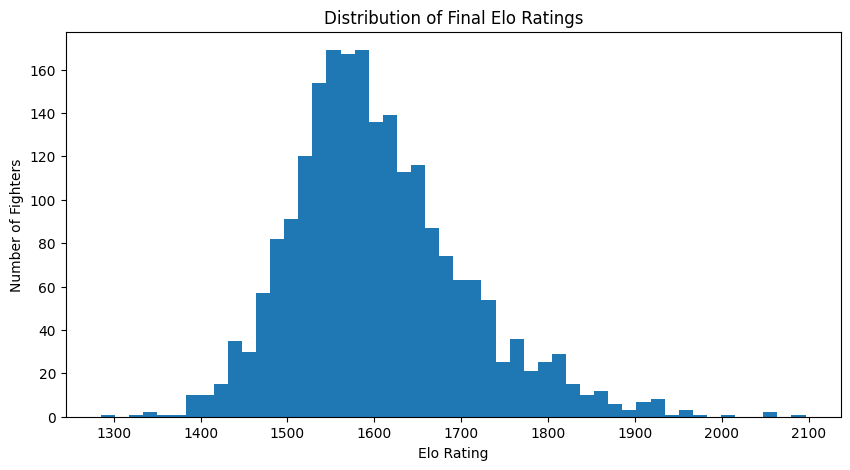

In [299]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(final_elos, bins=50)
plt.title("Distribution of Final Elo Ratings")
plt.xlabel("Elo Rating")
plt.ylabel("Number of Fighters")
plt.show()


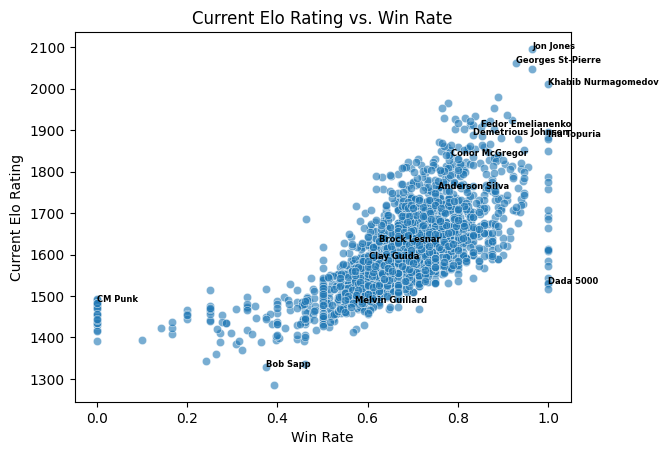

In [300]:
# Create win rates
fighter_stats = full_fight_df.groupby('fighter').agg(
    wins=('result', lambda x: (x == 'Win').sum()),
    total=('result', 'count')
)
fighter_stats['win_rate'] = fighter_stats['wins'] / fighter_stats['total']

# Merge with Elo
fighter_stats = fighter_stats.merge(final_elos, left_index=True, right_index=True)

# Optional: scatterplot
import seaborn as sns

# Fighters you want to label (use exact names from your dataset)
highlighted = ['Jon Jones', 'Fedor Emelianenko', 'Anderson Silva', 'Georges St-Pierre', 'Khabib Nurmagomedov', 'Demetrious Johnson', 'Clay Guida', 'Conor McGregor', 'Melvin Guillard', 'Bob Sapp', 'Brock Lesnar', 'CM Punk', 'Dada 5000', 'Ilia Topuria']

for name in highlighted:
    if name in fighter_stats.index:
        row = fighter_stats.loc[name]
        plt.text(row['win_rate'], row['final_elo'], name, fontsize=6, weight='semibold')

sns.scatterplot(data=fighter_stats, x='win_rate', y='final_elo', alpha=0.6)
plt.title("Current Elo Rating vs. Win Rate")
plt.xlabel("Win Rate")
plt.ylabel("Current Elo Rating")
plt.show()


In [301]:
# Fighter perspective
fighter_view = elo_df[['date', 'fighter', 'opponent', 'result', 'elo_f1_post']].copy()
fighter_view.columns = ['date', 'name', 'opponent', 'result', 'elo',]
fighter_view['perspective'] = 'fighter'

# Opponent perspective
# Flip the result for opponent (Win ↔ Loss; Draw → Draw; NC → NC)
def flip_result(r):
    if r == 'Win':
        return 'Loss'
    elif r == 'Loss':
        return 'Win'
    else:
        return r

opponent_view = elo_df[['date', 'opponent', 'fighter', 'result', 'elo_f2_post']].copy()
opponent_view.columns = ['date', 'name', 'opponent', 'result', 'elo']
opponent_view['result'] = opponent_view['result'].apply(flip_result)
opponent_view['perspective'] = 'opponent'

# Combine both
elo_long = pd.concat([fighter_view, opponent_view], ignore_index=True)

# Sort chronologically
elo_long = elo_long.sort_values(by='date').reset_index(drop=True)


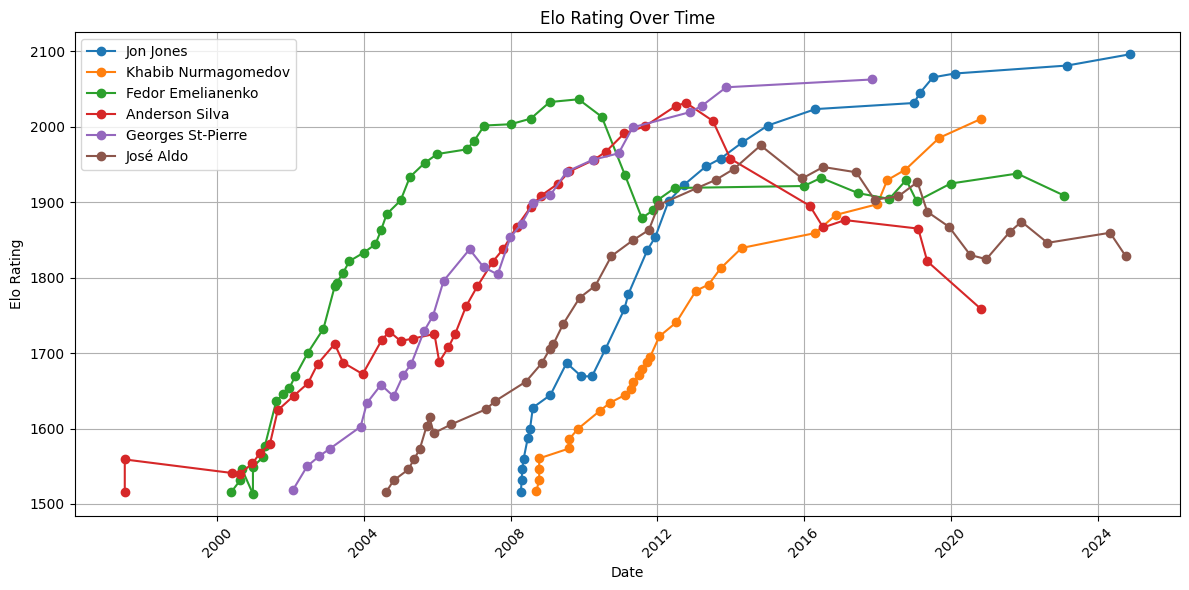

In [302]:


def plot_multiple_elo_trajectories(fighter_names):
    plt.figure(figsize=(12, 6))

    for fighter in fighter_names:
        fighter_data = elo_df[elo_df['fighter'] == fighter].sort_values(by='date')
        if not fighter_data.empty:
            plt.plot(fighter_data['date'], fighter_data['elo_f1_post'], marker='o', label=fighter)
        else:
            print(f"No data found for: {fighter}")


    plt.title("Elo Rating Over Time")
    plt.xlabel("Date")
    plt.ylabel("Elo Rating")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_multiple_elo_trajectories(["Jon Jones", "Khabib Nurmagomedov", "Fedor Emelianenko", "Anderson Silva", "Georges St-Pierre", "José Aldo"])


In [303]:
max_elo_per_fighter = (
    elo_df.groupby('fighter')['elo_f1_post']
    .max()
    .sort_values(ascending=False)
    .rename('max_elo')
    .round(2)
    .reset_index()
)

print(max_elo_per_fighter.head(25))

                  fighter  max_elo
0               Jon Jones  2096.15
1       Georges St-Pierre  2062.76
2         Islam Makhachev  2048.53
3       Fedor Emelianenko  2036.54
4          Anderson Silva  2031.70
5          Daniel Cormier  2028.97
6            Kamaru Usman  2012.06
7     Khabib Nurmagomedov  2010.34
8          Gegard Mousasi  1989.18
9        Charles Oliveira  1989.08
10  Alexander Volkanovski  1988.72
11         Belal Muhammad  1979.89
12           Leon Edwards  1977.58
13              José Aldo  1975.38
14           Max Holloway  1974.50
15             Ryan Bader  1971.87
16         Dustin Poirier  1971.38
17         Donald Cerrone  1970.87
18      Aljamain Sterling  1961.55
19           Stipe Miocic  1961.04
20          Tony Ferguson  1958.90
21        Israel Adesanya  1956.03
22        Glover Teixeira  1946.48
23     Demetrious Johnson  1946.29
24       Magomed Ankalaev  1936.25


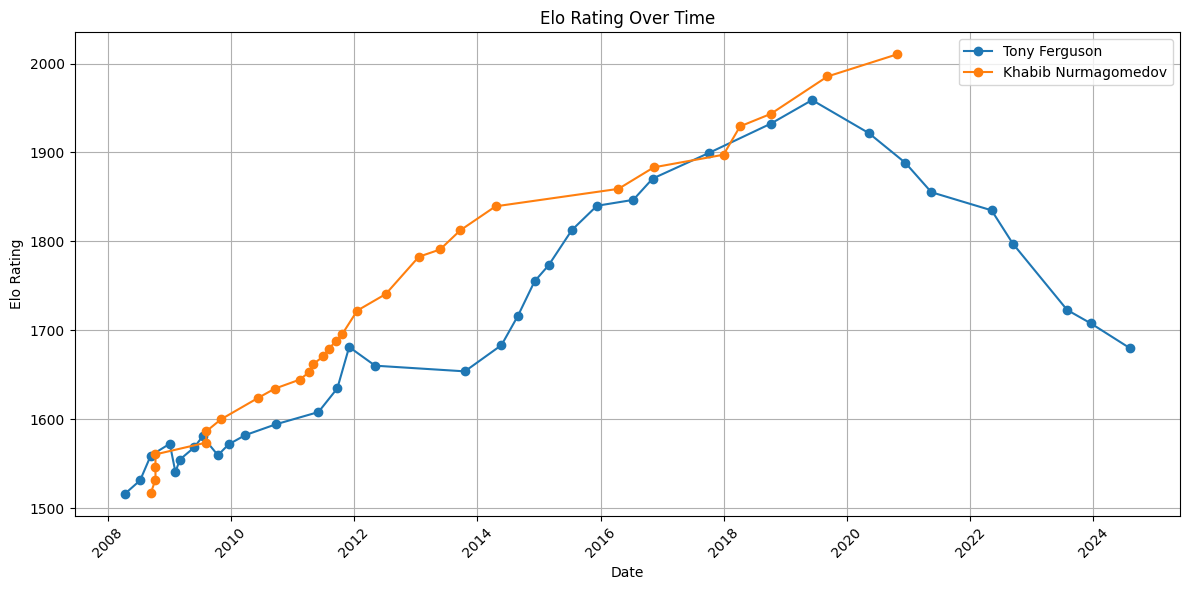

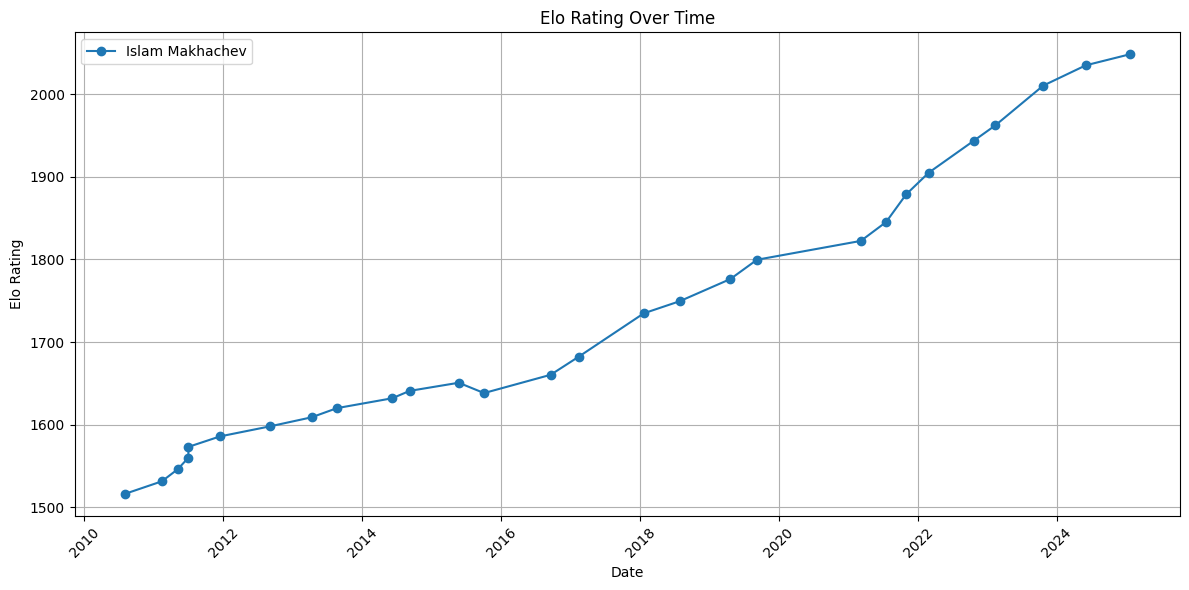

In [304]:
def plot_multiple_elo_trajectories(fighter_names):
    plt.figure(figsize=(12, 6))

    for fighter in fighter_names:
        fighter_data = elo_df[elo_df['fighter'] == fighter].sort_values(by='date')
        if not fighter_data.empty:
            plt.plot(fighter_data['date'], fighter_data['elo_f1_post'], marker='o', label=fighter)
        else:
            print(f"No data found for: {fighter}")


    plt.title("Elo Rating Over Time")
    plt.xlabel("Date")
    plt.ylabel("Elo Rating")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_multiple_elo_trajectories(["Tony Ferguson", "Khabib Nurmagomedov"])
plot_multiple_elo_trajectories(["Islam Makhachev"])


In [305]:
K_BASE = 32
K_FINISH_BONUS = 4       # Bonus for fights that end in a finish
K_TITLE_BONUS = 12        # Bonus for championship fights


In [306]:
elo_ratings = {}
elo_history_extended = []

for _, row in full_fight_df.sort_values(by='date').iterrows():
    f1 = row['fighter']
    f2 = row['opponent']
    result = row['result']
    is_finish = row['finish']  # True/False
    is_title = row['championship_fight']  # True/False

    # Initialize Elo
    elo_f1 = elo_ratings.get(f1, base_elo)
    elo_f2 = elo_ratings.get(f2, base_elo)

    if result == 'NC':
        continue

    # Determine match result from f1's POV
    if result == 'Win':
        score_f1 = 1
    elif result == 'Loss':
        score_f1 = 0
    elif result == 'Draw':
        score_f1 = 0.5
    else:
        continue

    # Dynamically adjust K
    K = K_BASE
    if is_finish:
        K += K_FINISH_BONUS
    if is_title:
        K += K_TITLE_BONUS

    # Update Elo ratings
    expected_f1 = 1 / (1 + 10 ** ((elo_f2 - elo_f1) / 400))
    new_elo_f1 = elo_f1 + K * (score_f1 - expected_f1)
    new_elo_f2 = elo_f2 + K * ((1 - score_f1) - (1 - expected_f1))

    # Save updated ratings
    elo_ratings[f1] = new_elo_f1
    elo_ratings[f2] = new_elo_f2

    # Store for output
    elo_history_extended.append({
        'date': row['date'],
        'fighter': f1,
        'opponent': f2,
        'result': result,
        'finish': is_finish,
        'championship': is_title,
        'elo_f1_pre': round(elo_f1, 2),
        'elo_f2_pre': round(elo_f2, 2),
        'elo_f1_post': round(new_elo_f1, 2),
        'elo_f2_post': round(new_elo_f2, 2)
    })


In [307]:
elo_df_expanded = pd.DataFrame(elo_history_extended)

In [308]:
max_elo_per_fighter_expanded = (
    elo_df_expanded.groupby('fighter')['elo_f1_post']
    .max()
    .sort_values(ascending=False)
    .rename('max_elo')
    .round(2)
    .reset_index()
)

print(max_elo_per_fighter_expanded.head(25))

                  fighter  max_elo
0               Jon Jones  2210.12
1       Georges St-Pierre  2168.03
2         Islam Makhachev  2129.97
3          Anderson Silva  2127.40
4       Fedor Emelianenko  2107.28
5          Daniel Cormier  2106.99
6            Kamaru Usman  2088.62
7            Stipe Miocic  2074.32
8        Charles Oliveira  2070.85
9     Khabib Nurmagomedov  2069.15
10  Alexander Volkanovski  2066.95
11              José Aldo  2053.91
12           Max Holloway  2032.57
13           Leon Edwards  2032.15
14             Ryan Bader  2030.53
15         Dustin Poirier  2029.96
16         Gegard Mousasi  2027.09
17     Demetrious Johnson  2023.40
18        Israel Adesanya  2023.30
19      Aljamain Sterling  2015.98
20          Tyron Woodley  2010.67
21          Tony Ferguson  2005.18
22        Glover Teixeira  1999.11
23         Belal Muhammad  1998.60
24        Francis Ngannou  1997.35


In [311]:
# Original final Elo
final_elo_original = elo_df.groupby('fighter')['elo_f1_post'].last().rename('elo_original')

# Extended final Elo
final_elo_expanded = elo_df_expanded.groupby('fighter')['elo_f1_post'].last().rename('elo_expanded')


In [312]:
elo_comparison = pd.concat([final_elo_original, final_elo_expanded], axis=1)
elo_comparison = elo_comparison.dropna()  # Keep fighters that appear in both
elo_comparison['elo_diff'] = (elo_comparison['elo_expanded'] - elo_comparison['elo_original']).round(2)


In [313]:
# Fighters who gained the most from finishes/title fights
top_boosted = elo_comparison.sort_values(by='elo_diff', ascending=False).head(10)
print("Top Boosted Fighters:\n", top_boosted)

# Fighters who were hurt by the new weighting
top_penalized = elo_comparison.sort_values(by='elo_diff').head(10)
print("\nTop Penalized Fighters:\n", top_penalized)


Top Boosted Fighters:
                    elo_original  elo_expanded  elo_diff
fighter                                                
Jon Jones               2096.15       2210.12    113.97
Georges St-Pierre       2062.76       2168.03    105.27
Islam Makhachev         2048.53       2129.97     81.44
Alex Pereira            1860.60       1940.88     80.28
Francis Ngannou         1918.00       1997.35     79.35
Stipe Miocic            1917.38       1994.45     77.07
Daniel Cormier          1953.12       2030.07     76.95
Amanda Nunes            1855.31       1926.08     70.77
Ben Askren              1817.62       1887.05     69.43
Julianna Peña           1683.18       1749.83     66.65

Top Penalized Fighters:
                  elo_original  elo_expanded  elo_diff
fighter                                              
Maiquel Falcão        1492.32       1458.10    -34.22
Andre Roberts         1629.74       1601.02    -28.72
Travis Fulton         1668.46       1639.92    -28.54
Mikuru As

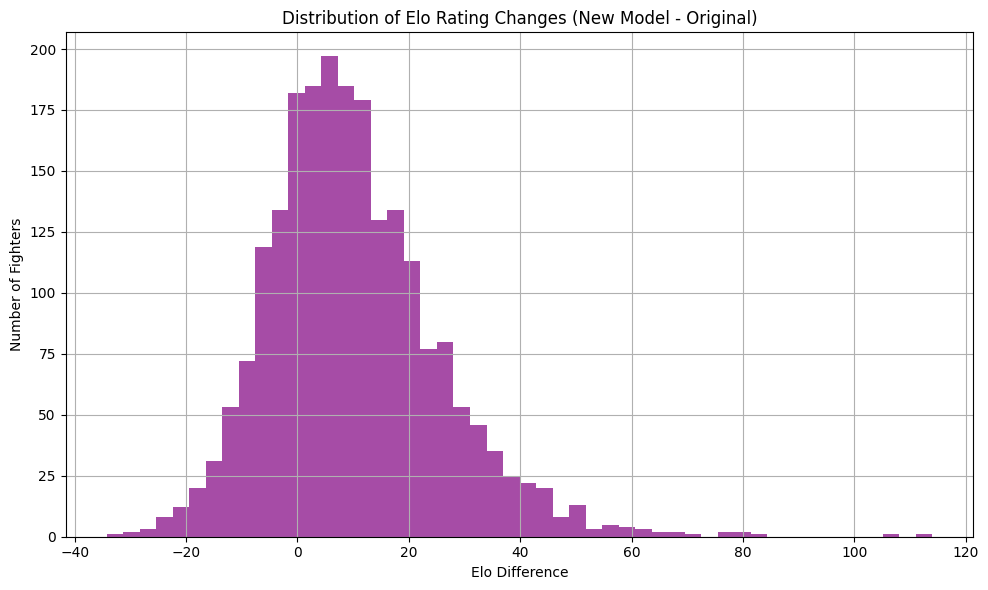

In [314]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(elo_comparison['elo_diff'], bins=50, color='purple', alpha=0.7)
plt.title("Distribution of Elo Rating Changes (New Model - Original)")
plt.xlabel("Elo Difference")
plt.ylabel("Number of Fighters")
plt.grid(True)
plt.tight_layout()
plt.show()
